In [210]:
%matplotlib inline
from matplotlib.patches import Polygon
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import numpy as np
from io import StringIO
import requests,json,os
import geopandas as gpd
import os
import csv
import os
import matplotlib as mpl

import matplotlib as plt
typeface='Helvetica Neue'
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22


# Define paths
base_path = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/'
meta_path = os.path.join(base_path, 'Metada_annotated.csv')

# Initialize metadata dictionary
metadata = {}

# Define the path to the metadata CSV file
meta_path = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Metada_annotated.csv'

# Parse the CSV file
with open(meta_path, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        sample_id = row['S/N']  # Use a unique identifier for each sample
        metadata[sample_id] = {
            'oldIDseqName': row['oldIDseqName'],
            'newIDseqName': row['NewIDseqName'],
            'ska_genus': row['ska_genus'],
            'ska_species': row['ska_species'],
            'collected_by': row['collected_by'],
            'collection_lat': row['collection_lat'],
            'collection_long': row['collection_long'],
        }
        
print("Sample metadata entry:", list(metadata.items())[:1])  # Print the first sample

Sample metadata entry: [('10', {'oldIDseqName': 'AIAMACAT001', 'newIDseqName': 'AIAMACAT001_S69_657769', 'ska_genus': 'Feline', 'ska_species': 'Cat', 'collected_by': 'Ebonyi', 'collection_lat': '6.2649', 'collection_long': '8.0137'})]


In [212]:
genera_values = {}
species_values = {}
loc_points = {}
sample_stats = {}

for sample_id, sample_data in metadata.items():
    loc = sample_data.get('collected_by', 'NA').strip()  # Strip spaces from location
    genus = sample_data.get('ska_genus', '')
    species = sample_data.get('ska_species', '')

    sp = f'{genus} {species}'
    sample_stats[sample_id] = {'loc': loc, 'genus': genus, 'species': species}

    if genus and sample_data.get('collection_lat', 'NA') != 'NA':
        try:
            lat = float(sample_data['collection_lat'])
            lon = float(sample_data['collection_long'])

            if loc not in genera_values:
                genera_values[loc] = {}
                species_values[loc] = {}
                loc_points[loc] = (lon, lat)

            genera_values[loc][genus] = genera_values[loc].get(genus, 0) + 1
            species_values[loc][sp] = species_values[loc].get(sp, 0) + 1
        except ValueError as e:
            print(f"Invalid coordinate for sample {sample_id}: {e}")

# Debugging output
print("Genera values:", genera_values)
print("Species values:", species_values)
print("Location points:", loc_points)

Dog= 23+18

Genera values: {'Ebonyi': {'Feline': 1, 'Avian': 3, 'Canine': 10, 'Caprine': 24, 'Saurian': 2, 'Swine': 4, 'Rat': 46, 'Ovine': 7}, 'Ondo': {'Bat': 10, 'Feline': 1, 'Avian': 1, 'Canine': 23, 'Cattle': 10, 'Caprine': 23, 'Saurian': 1, 'Rat': 59, 'Ovine': 3, 'Squirrel': 10}}
Species values: {'Ebonyi': {'Feline Cat': 1, 'Avian Chicken': 3, 'Canine Dog': 10, 'Caprine Goat': 24, 'Saurian Lizard': 2, 'Swine Pig': 4, 'Rat Rodent': 46, 'Ovine Sheep': 7}, 'Ondo': {'Bat Bat': 10, 'Feline Cat': 1, 'Avian Chicken': 1, 'Canine Dog': 23, 'Cattle Egret': 10, 'Caprine Goat': 23, 'Saurian Lizard': 1, 'Rat Rodent': 59, 'Ovine Sheep': 3, 'Squirrel Squirrel': 10}}
Location points: {'Ebonyi': (8.0137, 6.2649), 'Ondo': (5.147, 6.9149)}


In [214]:
# Load the GeoJSON file as a GeoDataFrame
geo_df = gpd.read_file('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/gadm41_NGA_1.json')

# Ensure the GeoDataFrame uses the EPSG:4326 CRS
geo_df = geo_df.to_crs("EPSG:4326")

# Dictionaries to store location points and polygons
location_points = {}
polygons = {}

# Key for location names in GeoJSON properties
locName = 'NAME_1'  # Update to match the property name in your GeoJSON

# Process each row in the GeoDataFrame
for _, row in geo_df.iterrows():
    location = row[locName]  # Get location name
    geom = row['geometry']  # Get geometry (can be Polygon or MultiPolygon)

    if not location:
        continue  # Skip if location name is missing

    # Initialize lists for this location
    polygons[location] = []
    location_points[location] = []

    if geom.geom_type == 'MultiPolygon':  # If the geometry is a MultiPolygon
        for poly in geom.geoms:  # Iterate over individual polygons
            coords = np.array(poly.exterior.coords)
            xs, ys = coords[:, 0], coords[:, 1]  # Separate x and y
            location_points[location].append(np.vstack((xs, ys)).T)
            polygons[location].append(poly)

    elif geom.geom_type == 'Polygon':  # If the geometry is a Polygon
        coords = np.array(geom.exterior.coords)
        xs, ys = coords[:, 0], coords[:, 1]  # Separate x and y
        location_points[location].append(np.vstack((xs, ys)).T)
        polygons[location].append(geom)

# Assign colors for locations
sample_colour = {
    'Ondo': 'red',  # Purple
    'Ebonyi': 'Steelblue'  # Yellow
}
rename = {'Ondo': 'Ondo State', 'Ebonyi': 'Ebonyi State'}

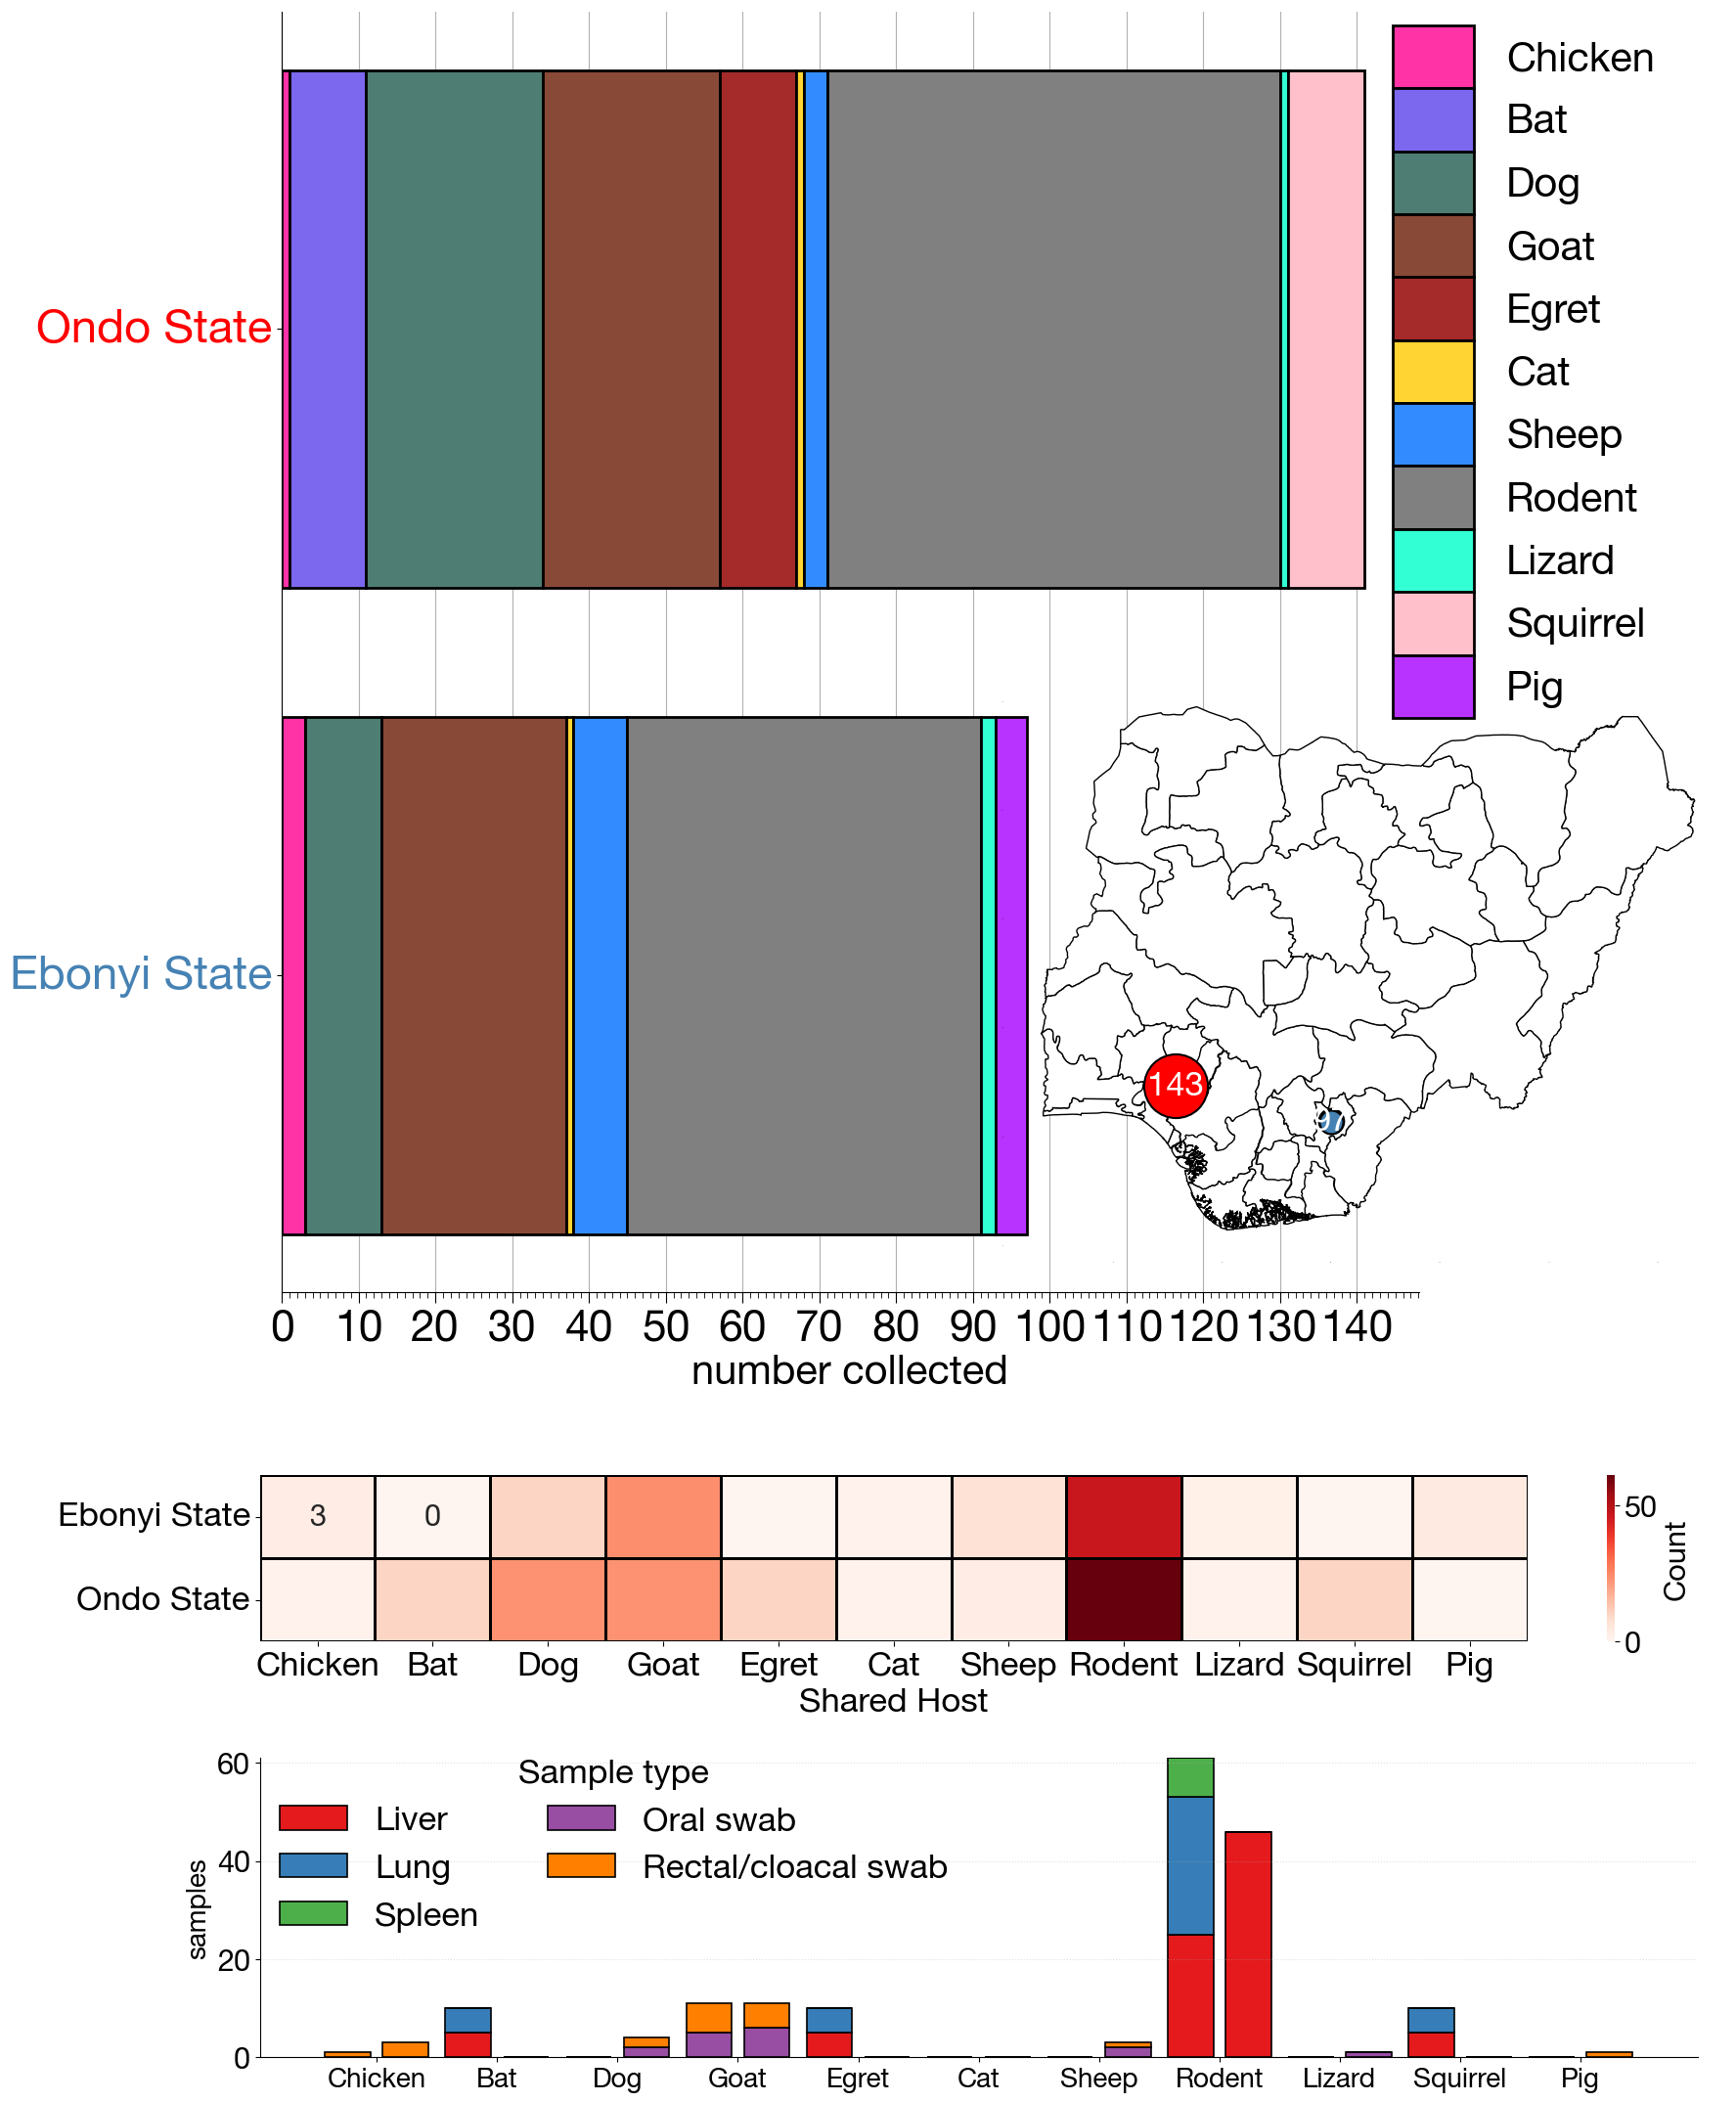

In [216]:


import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 17),facecolor='w')
gs = gridspec.GridSpec(1,1,wspace=0)


ax=plt.subplot(gs[0],facecolor='w')

subax=fig.add_axes([0.62, 0.07, 0.49, 0.47], frame_on=False)
subax.set_aspect(1)

genera_colours = {
    'Avian': '#FF33FF',         # Bright magenta
    'Bat': '#7B68EE',
    'Canine': '#FF5733',        # Bright orange
    'Caprine': '#33FF57',       # Bright green
    'Cattle': '#A52A2A',
    'Feline': '#F4C300',        # Bright yellow
    'Ovine': '#3357FF',         # Bright blue
    'Rat': 'grey',
    'Saurian': '#33FFF5',       # Cyan
    'Squirrel': '#FFC0CB',
    'Swine': '#8C33FF'          # Purple
}

species_colours = {
    'Avian Chicken': '#FF33A6',      # Lighter magenta
    'Bat Bat': '#7B68EE',
    'Canine Dog': '#4D7D73',         # Lighter orange
    'Caprine Goat': '#884936',       # Lighter green
    'Cattle Egret': '#A52A2A',
    'Feline Cat': '#FFD433',         # Lighter yellow
    'Ovine Sheep': '#338CFF',        # Lighter blue
    'Rat Rodent': 'grey',
    'Saurian Lizard': '#33FFD4',     # Lighter cyan
    'Squirrel Squirrel': '#FFC0CB',
    'Swine Pig': '#B833FF'           # Lighter purple
}


loc_labels=sorted(genera_values,key=lambda k: loc_points[k][1])

species_by_genera={g: set(sum([[w for w in k if w.split(' ')[0]==g] for k in species_values.values()],[])) for g in genera_colours}
species_to_genus={k.split(' ')[1]: k.split(' ')[0] for k in sum(map(list,species_values.values()),[])}

hatches=['','/','\\','x']
species_hatches={g: {sp: hatches[s] for s,sp in enumerate(sorted(species_by_genera[g]))} for g in genera_colours}

for i,loc in enumerate(loc_labels):
    gens=sorted(genera_values[loc])
    spp=sorted(species_values[loc])
    for j in range(len(spp)):
        value=species_values[loc][spp[j]]
        #h=species_hatches[spp[j].split(' ')[0]][spp[j]]
        h=''
        genus=spp[j].split(' ')[0]
        bottom=sum([species_values[loc][genus] for genus in spp[:j]])
        
        fc=genera_colours[genus]
        fc=species_colours[spp[j]]
        
        labels=ax.get_legend_handles_labels()[1]
        label=spp[j].split(' ')[1] if spp[j].split(' ')[1] not in labels else ''
        ax.barh(i,value,left=bottom,facecolor=fc,hatch=h,
                edgecolor='k',lw=2,label=label,zorder=100)
        
ax.set_yticks(range(len(loc_labels)))
ax.set_yticklabels(loc_labels,size=44,weight=500)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

for loc in ax.get_yticklabels():
    loc.set_color(sample_colour[loc.get_text()])
ax.set_yticklabels([rename[x] for x in loc_labels],size=34,weight=500,va='center',ha='right')



boxes,labels=ax.get_legend_handles_labels()
boxes,labels=zip(*sorted(zip(boxes,labels),key=lambda k: (species_to_genus[k[1]],k[1])))
ax.legend(boxes,labels,loc=4,ncol=1,bbox_to_anchor=(1.24,0.42),fontsize=30,handlelength=2,handleheight=2,labelspacing=0.0,frameon=False)


[ax.spines[side].set_visible(False) for side in ax.spines if side not in ['bottom','left']]
ax.grid(axis='x')
ax.set_xlabel('number collected',size=30)
ax.tick_params(axis='x',which='major',size=8,labelsize=32)
ax.tick_params(axis='x',which='minor',size=4,labelsize=0)


subax.tick_params(size=0,labelsize=0)
[subax.spines[side].set_visible(False) for side in subax.spines]

for loc in sample_colour:
    if loc!='NA':
        subax.scatter(*loc_points[loc],s=200,facecolor=sample_colour[loc],edgecolor='none',zorder=10)
        subax.scatter(*loc_points[loc],s=400,facecolor='k',edgecolor='none',zorder=9)

for loc in polygons:
    mpl_polygons = [MplPolygon(np.array(p.exterior.coords), closed=True) for p in polygons[loc]]
    county = PatchCollection(mpl_polygons, facecolor='w', edgecolor='k', zorder=0)
    subax.add_collection(county)
subax.plot()


# --- scale map circles by per-state totals and label them ---
# totals from the metadata frame you already loaded
totals_by_label = df.groupby("location_label").size()
short_to_full = {"Ondo":"Ondo State", "Ebonyi":"Ebonyi State"}

# size mapping (area in points^2). tweak min/max if you want.
min_s, max_s = 300, 2200
vmin = int(totals_by_label.min()) if len(totals_by_label) else 0
vmax = int(totals_by_label.max()) if len(totals_by_label) else 1

def size_for(n):
    if vmax == vmin:
        return (min_s + max_s) / 2.0
    return np.interp(n, [vmin, vmax], [min_s, max_s])

# draw scaled, labeled circles
for loc in sample_colour:
    if loc != 'NA' and loc in loc_points:
        lon, lat = loc_points[loc]
        n = int(totals_by_label.get(short_to_full.get(loc, loc), 0))
        s = size_for(n)
        subax.scatter(lon, lat, s=s, facecolor=sample_colour[loc], edgecolor='k', linewidth=1.5, zorder=10)
        # centered count label
        subax.text(lon, lat, f"{n}", ha='center', va='center',
                   fontsize=25, color='white', weight='bold', zorder=11)

# add a tiny size legend inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
leg_ax = inset_axes(subax, width="55%", height="38%", loc="lower right", borderpad=1.0)
leg_ax.set_axis_off()


#plt.savefig("/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/latest_Demography.png", bbox_inches='tight',dpi=300)
#plt.savefig("/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/latest_Demography.pdf", bbox_inches='tight',dpi=300)

# --- NEW: Panel for sample types per host ------------------------------------
import pandas as pd

# Read the same metadata with pandas so we can group easily
df = pd.read_csv(meta_path)

# Clean up / normalize a few columns we’ll use
df["location"] = df["collected_by"].str.strip()
df["location_label"] = df["location"].map({"Ondo":"Ondo State","Ebonyi":"Ebonyi State"}).fillna(df["location"])

# Map genus to the common names you’re using in the figure
genus_to_common = {
    "Avian":"Chicken", "Bat":"Bat", "Canine":"Dog", "Caprine":"Goat", "Cattle":"Egret",
    "Feline":"Cat", "Ovine":"Sheep", "Rat":"Rodent", "Saurian":"Lizard",
    "Squirrel":"Squirrel", "Swine":"Pig"
}
df["host_common"] = df["ska_genus"].map(genus_to_common).fillna(df["ska_genus"].str.title())

# Normalize sample_type values into a small, consistent set
def norm_sample_type(x: str) -> str:
    x = (str(x) or "").strip().lower()
    if x in {"liv","liver"}: return "Liver"
    if x in {"lun","lung"}: return "Lung"
    if x in {"spl","spleen"}: return "Spleen"
    if "oral" in x: return "Oral swab"
    if "rect" in x or "cloac" in x: return "Rectal/cloacal swab"
    return x.title() if x else "Other"

df["sample_type_norm"] = df["sample_type"].apply(norm_sample_type)

# The host order you’re using in the main panel (tweak if you want a different order)
host_order = ["Chicken","Bat","Dog","Goat","Egret","Cat","Sheep","Rodent","Lizard","Squirrel","Pig"]

# Sample-type palette (distinct but color-blind friendly). Feel free to change.
sample_type_colours = {
    "Liver":        "#e41a1c",
    "Lung":         "#377eb8",
    "Spleen":       "#4daf4a",
    "Oral swab":    "#984ea3",
    "Rectal/cloacal swab": "#ff7f00",
    "Other":        "#999999"
}
sample_type_order = [k for k in ["Liver","Lung","Spleen","Oral swab","Rectal/cloacal swab","Other"]
                     if k in df["sample_type_norm"].unique()]

# Aggregate counts
counts = (df.groupby(["location_label","host_common","sample_type_norm"])
            .size().reset_index(name="n"))

# Make a compact panel under the main bar to show sample-type composition per host and location
# [left, bottom, width, height] — adjust the bottom if you need more/less spacing
ax_types = fig.add_axes([0.11, -0.35, 0.98, 0.18], facecolor='w')  # under main ax

# Build side-by-side stacks for Ondo vs Ebonyi per host
locs = [lbl for lbl in [rename.get("Ondo","Ondo State"), rename.get("Ebonyi","Ebonyi State")]
        if lbl in counts["location_label"].unique()]
bar_width = 0.38
gap = 0.10

x_hosts = [h for h in host_order if h in counts["host_common"].unique()]
x_pos = np.arange(len(x_hosts))

for i, loclbl in enumerate(locs):
    sub = counts[counts["location_label"]==loclbl]
    bottoms = np.zeros(len(x_hosts))
    # offset the bars a bit so locations sit side-by-side per host
    offset = (i - (len(locs)-1)/2) * (bar_width + gap)
    for st in sample_type_order:
        y = np.array([sub.loc[(sub["host_common"]==h) &
                              (sub["sample_type_norm"]==st), "n"].sum() for h in x_hosts])
        ax_types.bar(x_pos + offset, y, width=bar_width,
                     bottom=bottoms,
                     edgecolor='k', linewidth=1.2,
                     label=st if (i==0) else "",
                     color=sample_type_colours.get(st, "#999999"))
        bottoms += y
    # location tick markers on top of each little cluster
    #ax_types.text(x_pos[-1] + offset + 0.35, ax_types.get_ylim()[1]*0.96,
     #             loclbl.split()[0], ha='right', va='top', fontsize=16)

# Axes cosmetics
ax_types.set_xticks(x_pos)
ax_types.set_xticklabels(x_hosts, rotation=0, ha='center', fontsize=20)
ax_types.set_ylabel("samples", fontsize=20)
ax_types.set_ylim(0, max(1, ax_types.get_ylim()[1]))
[ax_types.spines[s].set_visible(False) for s in ["top","right"]]
ax_types.grid(axis="y", linestyle=":", alpha=0.4)

# Legend for sample types (one copy)
leg = ax_types.legend(title="Sample type", ncol=2, fontsize=25, title_fontsize=25,
                      frameon=False, bbox_to_anchor=(0.5, 1.1), loc="upper right")



# --- NEW: Host × State (raw counts) heatmap --------------------------
import seaborn as sns

# pivot counts directly from metadata
host_counts = (df.groupby(["location_label","host_common"])
                 .size()
                 .unstack(fill_value=0))

# order rows/cols to match figure
row_order = [rename.get("Ebonyi","Ebonyi State"), rename.get("Ondo","Ondo State")]
row_order = [r for r in row_order if r in host_counts.index]
col_order = [h for h in host_order if h in host_counts.columns]
host_counts = host_counts.loc[row_order, col_order]

# axes placement (under the sample-type panel). adjust if needed.
ax_counts = fig.add_axes([0.11, -.1, 1.08, 0.1], facecolor='w')
sns.heatmap(host_counts, annot=True, fmt="d",
            cmap="Reds", cbar_kws={"label":"Count"},
            linewidths=1, linecolor="black", ax=ax_counts)

ax_counts.set_xlabel("Shared Host", fontsize=25)
ax_counts.set_ylabel("")
ax_counts.tick_params(axis='x', labelrotation=0, labelsize=25)
ax_counts.tick_params(axis='y', labelrotation=0, labelsize=25)




Tree height: 318.950000
Tree length: 1454.658080
strictly bifurcating tree
annotations present

Numbers of objects in tree: 21 (10 nodes and 11 leaves)

Tree height (root-to-tip): 318.95000000000005


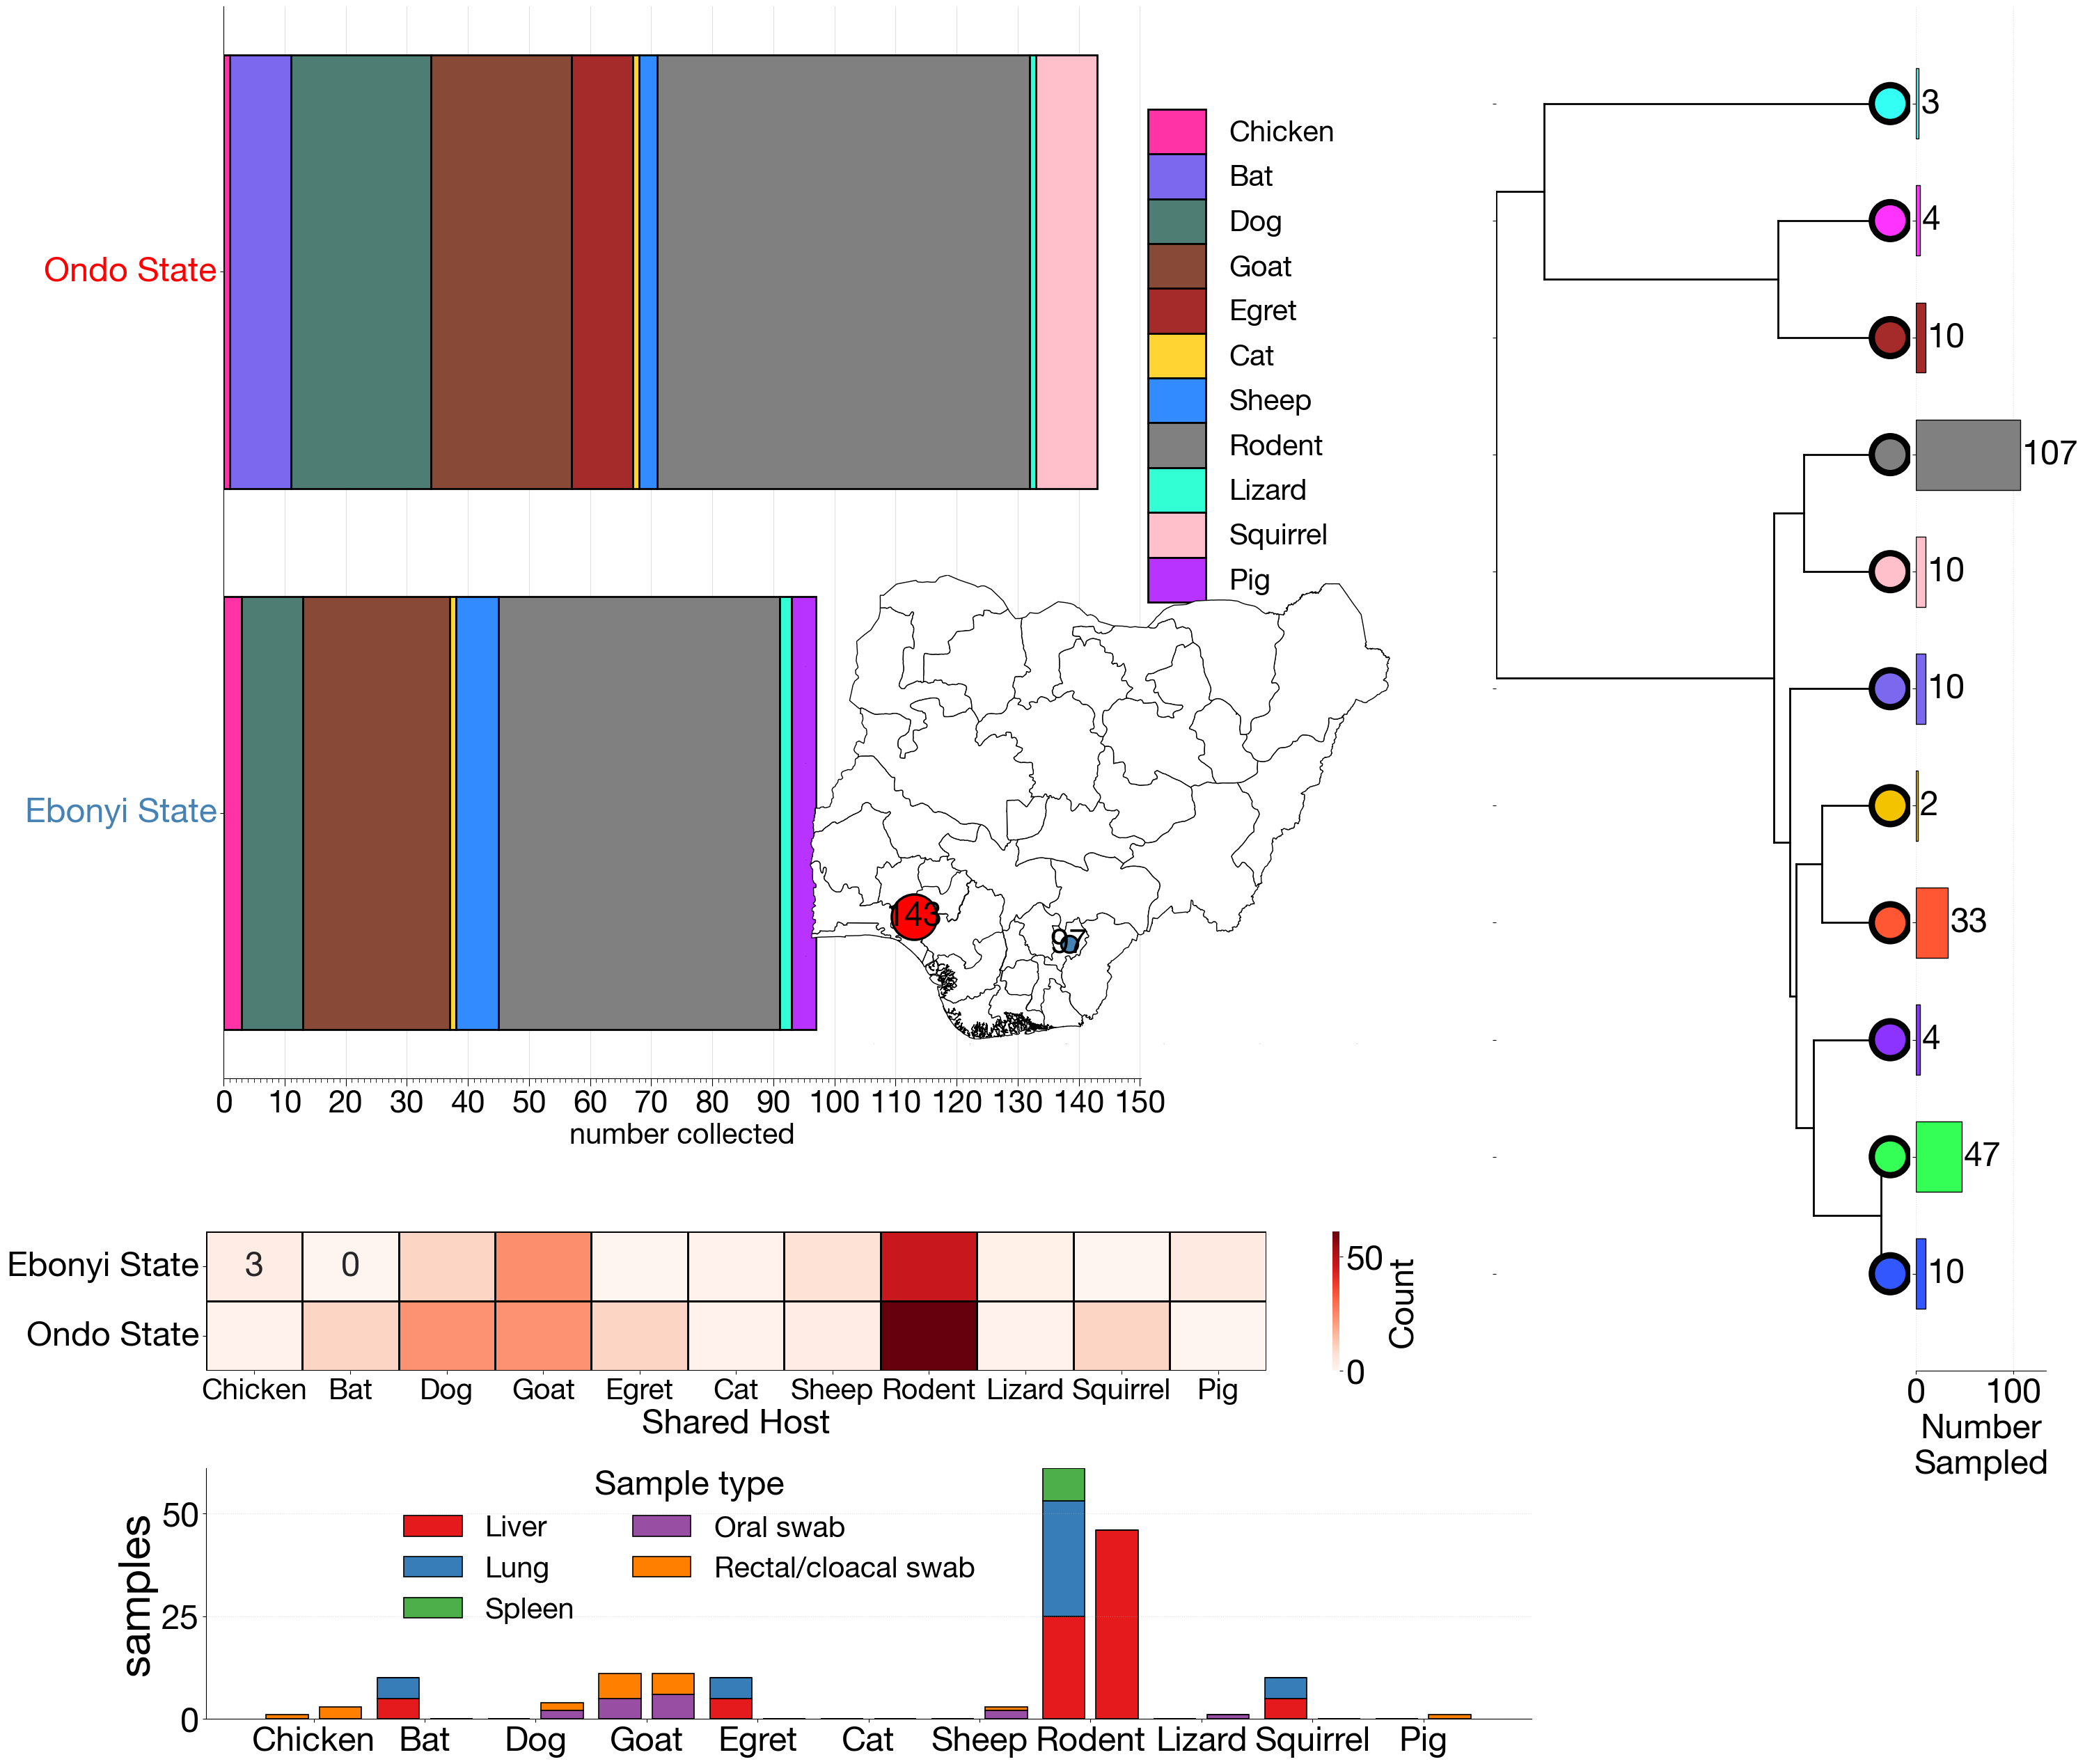

In [35]:
# --- Fig.1 (Sampling): host counts, sample types, and map with scaled circles ---





# Std libs & plotting
import os, csv, numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import seaborn as sns
import geopandas as gpd

# --------------------
# Config / aesthetics
# --------------------
typeface = 'Helvetica Neue'
mpl.rcParams['font.family'] = typeface
mpl.rcParams['font.size']   = 35

# Paths
meta_path   = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Metada_annotated.csv'
nga_geojson = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/gadm41_NGA_1.json'
out_base    = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Fig1_Sampling'

# Location labels/colors
rename        = {'Ondo': 'Ondo State', 'Ebonyi': 'Ebonyi State'}
sample_colour = {'Ondo': 'red', 'Ebonyi': 'Steelblue'}

# Host color maps (genus + species key for consistent hues)
genera_colours = {
    'Avian':'#FF33FF','Bat':'#7B68EE','Canine':'#FF5733','Caprine':'#33FF57','Cattle':'#A52A2A',
    'Feline':'#F4C300','Ovine':'#3357FF','Rat':'grey','Saurian':'#33FFF5','Squirrel':'#FFC0CB','Swine':'#8C33FF'
}
species_colours = {
    'Avian Chicken':'#FF33A6','Bat Bat':'#7B68EE','Canine Dog':'#4D7D73','Caprine Goat':'#884936',
    'Cattle Egret':'#A52A2A','Feline Cat':'#FFD433','Ovine Sheep':'#338CFF','Rat Rodent':'grey',
    'Saurian Lizard':'#33FFD4','Squirrel Squirrel':'#FFC0CB','Swine Pig':'#B833FF'
}

# Host display order & sample-type palette
host_order = ["Chicken","Bat","Dog","Goat","Egret","Cat","Sheep","Rodent","Lizard","Squirrel","Pig"]
sample_type_colours = {
    "Liver":"#e41a1c","Lung":"#377eb8","Spleen":"#4daf4a",
    "Oral swab":"#984ea3","Rectal/cloacal swab":"#ff7f00","Other":"#999999"
}
sample_type_order = ["Liver","Lung","Spleen","Oral swab","Rectal/cloacal swab","Other"]

# --------------------
# Load metadata
# --------------------
df = pd.read_csv(meta_path)

# Normalize columns
df["location"]       = df["collected_by"].astype(str).str.strip()
df["location_label"] = df["location"].map(rename).fillna(df["location"])
df["genus_species"]  = (df["ska_genus"].astype(str).str.strip() + " " +
                        df["ska_species"].astype(str).str.strip())

# Common host names for panels using a stable mapping
genus_to_common = {
    "Avian":"Chicken","Bat":"Bat","Canine":"Dog","Caprine":"Goat","Cattle":"Egret",
    "Feline":"Cat","Ovine":"Sheep","Rat":"Rodent","Saurian":"Lizard",
    "Squirrel":"Squirrel","Swine":"Pig"
}
df["host_common"] = df["ska_genus"].map(genus_to_common).fillna(df["ska_genus"].str.title())

# Sample-type normalization
def norm_sample_type(x: str) -> str:
    x = (str(x) or "").strip().lower()
    if x in {"liv","liver"}: return "Liver"
    if x in {"lun","lung"}: return "Lung"
    if x in {"spl","spleen"}: return "Spleen"
    if "oral" in x: return "Oral swab"
    if "rect" in x or "cloac" in x: return "Rectal/cloacal swab"
    return x.title() if x else "Other"
df["sample_type_norm"] = df["sample_type"].apply(norm_sample_type)

# --------------------
# Nigeria basemap bits (robust, no filtering)
# --------------------
geo_df = gpd.read_file(nga_geojson).to_crs("EPSG:4326")
locName = 'NAME_1'  # verify with: print(geo_df.columns)

polygons   = {}
loc_points = {}

def norm(s): 
    return str(s).strip().lower()

# Map various ways the state might appear -> short key
alias_to_short = {
    'ondo': 'Ondo',
    'ondo state': 'Ondo',
    'ebonyi': 'Ebonyi',
    'ebonyi state': 'Ebonyi',
}

for _, row in geo_df.iterrows():
    state = row[locName]
    geom  = row.geometry

    # collect polygons for ALL states so the outline always draws
    if geom.geom_type == "MultiPolygon":
        polys = list(geom.geoms)
    elif geom.geom_type == "Polygon":
        polys = [geom]
    else:
        polys = []

    polygons[state] = polys

    # capture representative points for our two states (robust matching)
    short = alias_to_short.get(norm(state))
    if short and short not in loc_points:
        rp = geom.representative_point()  # safer than centroid for multipolygons
        loc_points[short] = (float(rp.x), float(rp.y))

# --------------------
# Precompute counts
# --------------------
# Panel A: stacked horizontal bars by state (species within genus)
gs_counts = (df.groupby(["location_label","genus_species"])
               .size().reset_index(name="n"))

# Sample-type panel
st_counts = (df.groupby(["location_label","ska_genus","sample_type_norm"])
               .size().reset_index(name="n"))

# Host × State heatmap (raw counts)
host_counts = (df.groupby(["location_label","host_common"])
                 .size()
                 .unstack(fill_value=0))

# --------------------
# Figure canvas
# --------------------
fig = plt.figure(figsize=(17,20), facecolor='w')

# Panel A: stacked horizontal bars by state
ax = fig.add_subplot(1,1,1, facecolor='w')

loc_labels = [rename.get("Ebonyi","Ebonyi State"), rename.get("Ondo","Ondo State")]
loc_labels = [l for l in loc_labels if l in gs_counts["location_label"].unique()]

# de-dup legend labels across both states
seen_species_labels = set()

for i, loclbl in enumerate(loc_labels):
    sub = gs_counts[gs_counts["location_label"] == loclbl]
    # order species by our color dict key order, then any extras by count
    keys_in_sub = [k for k in species_colours.keys() if k in sub["genus_species"].unique()]
    extra = [k for k in sub["genus_species"].unique() if k not in keys_in_sub]
    # sort extras by count descending for stability
    extra = sorted(extra, key=lambda k: int(sub.loc[sub["genus_species"]==k, "n"].sum()), reverse=True)
    order = keys_in_sub + extra

    left = 0
    for key in order:
        n = int(sub.loc[sub["genus_species"]==key, "n"].sum())
        if n == 0:
            continue
        genus  = key.split()[0]
        sp_lab = key.split()[-1].title()  # legend name
        face   = species_colours.get(key, genera_colours.get(genus, "#999999"))

        label = sp_lab if sp_lab not in seen_species_labels else ""
        ax.barh(i, n, left=left, facecolor=face, edgecolor='k', lw=2,
                label=label, zorder=100)
        if label:
            seen_species_labels.add(sp_lab)
        left += n

# y ticks and colors
ax.set_yticks(range(len(loc_labels)))
ax.set_yticklabels(loc_labels, size=35, weight=500, va='center', ha='right')
# color ticks by state color
for tick in ax.get_yticklabels():
    short = [k for k,v in rename.items() if v == tick.get_text()]
    if short:
        tick.set_color(sample_colour.get(short[0], 'k'))

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
[ax.spines[s].set_visible(False) for s in ax.spines if s not in ['bottom','left']]
ax.grid(axis='x', alpha=0.4)
ax.set_xlabel('number collected', size=30)
ax.tick_params(axis='x', which='major', size=8, labelsize=32)
ax.tick_params(axis='x', which='minor', size=4, labelsize=0)

# Legend (sorted by genus then species)
def species_to_genus(sp_name):
    for k in species_colours:
        if sp_name == k.split()[-1].title():
            return k.split()[0]
    return "ZZZ"
boxes, labels = ax.get_legend_handles_labels()
if boxes:
    boxes, labels = zip(*sorted(zip(boxes,labels), key=lambda t: (species_to_genus(t[1]), t[1])))
    ax.legend(boxes, labels, loc=4, ncol=1, bbox_to_anchor=(1.24,0.42),
              fontsize=30, handlelength=2, handleheight=2, labelspacing=0.0, frameon=False)

# --------------------
# MAP panel (scaled circles + fixed autoscale + clean legend)
# --------------------
# --------------------
# MAP panel (scaled circles + autoscale)
# --------------------
subax = fig.add_axes([0.62, 0.07, 0.49, 0.47], frame_on=False)
subax.set_aspect(1)
subax.tick_params(size=0, labelsize=0)
[subax.spines[s].set_visible(False) for s in subax.spines]

# draw ALL state polygons as background
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as MplPolygon
for state, polys in polygons.items():
    mpl_polys = [MplPolygon(np.array(p.exterior.coords), closed=True) for p in polys]
    if mpl_polys:
        subax.add_collection(PatchCollection(mpl_polys, facecolor='w', edgecolor='k', zorder=0))

# autoscale to Nigeria bounds
minx, miny, maxx, maxy = geo_df.total_bounds
subax.set_xlim(minx, maxx)
subax.set_ylim(miny, maxy)

# circle sizes scaled by totals per state
totals_by_label = df.groupby("location_label").size()
min_s, max_s = 300, 2200
vmin = int(totals_by_label.min()) if len(totals_by_label) else 0
vmax = int(totals_by_label.max()) if len(totals_by_label) else 1
def size_for(n):
    if vmin == vmax: 
        return (min_s + max_s) / 2.0
    return np.interp(n, [vmin, vmax], [min_s, max_s])

for short in ("Ondo","Ebonyi"):
    if short in loc_points:
        lon, lat = loc_points[short]
        full = rename.get(short, short)  # 'Ondo State' / 'Ebonyi State'
        n    = int(totals_by_label.get(full, 0))
        s    = size_for(n)
        subax.scatter(lon, lat, s=s, facecolor=sample_colour[short],
                      edgecolor='k', linewidth=2.5, zorder=10)
        subax.text(lon, lat, f"{n}", ha='center', va='center',
                   fontsize=35, color='black', weight='bold', zorder=11)


# --------------------
# Panel: sample types per host × state (stacked bars)
# --------------------
ax_types = fig.add_axes([0.11, -0.35, 1.12, 0.18], facecolor='w')  # under main ax
locs = [rename.get("Ondo","Ondo State"), rename.get("Ebonyi","Ebonyi State")]
locs = [l for l in locs if l in st_counts["location_label"].unique()]
bar_width, gap = 0.38, 0.10

# hosts present in data, ordered by host_order
hosts_present = df["host_common"].unique().tolist()
x_hosts = [h for h in host_order if h in hosts_present]
x_pos   = np.arange(len(x_hosts))

# order sample-type layers present in the data
layers = [s for s in sample_type_order if s in df["sample_type_norm"].unique()]

for i, loclbl in enumerate(locs):
    sub = st_counts[st_counts["location_label"] == loclbl].copy()
    sub["host_common"] = sub["ska_genus"].map(genus_to_common).fillna(sub["ska_genus"])
    bottoms = np.zeros(len(x_hosts))
    offset  = (i - (len(locs)-1)/2) * (bar_width + gap)
    for st in layers:
        y = np.array([sub.loc[(sub["host_common"]==h) &
                              (sub["sample_type_norm"]==st), "n"].sum() for h in x_hosts])
        ax_types.bar(x_pos + offset, y, width=bar_width, bottom=bottoms,
                     edgecolor='k', linewidth=1.2,
                     label=st if (i==0) else "",
                     color=sample_type_colours.get(st, "#999999"))
        bottoms += y

ax_types.set_xticks(x_pos)
ax_types.set_xticklabels(x_hosts, rotation=0, ha='center', fontsize=35)
ax_types.set_ylabel("samples", fontsize=45)
ax_types.set_ylim(0, max(1, ax_types.get_ylim()[1]))
[ax_types.spines[s].set_visible(False) for s in ["top","right"]]
ax_types.grid(axis="y", linestyle=":", alpha=0.4)
ax_types.legend(title="Sample type", ncol=2, fontsize=30, title_fontsize=35,
                frameon=False, bbox_to_anchor=(0.6, 1.1), loc="upper right")

# --------------------
# Panel: Host × State (raw counts) heatmap
# --------------------
row_order = [rename.get("Ebonyi","Ebonyi State"), rename.get("Ondo","Ondo State")]
row_order = [r for r in row_order if r in host_counts.index]
col_order = [h for h in host_order if h in host_counts.columns]
host_counts = host_counts.loc[row_order, col_order]

ax_counts = fig.add_axes([0.11, -0.10, 1.12, 0.10], facecolor='w')
sns.heatmap(host_counts, annot=True, fmt="d", cmap="Reds",
            cbar_kws={"label":"Count"}, linewidths=1, linecolor="black", ax=ax_counts)
ax_counts.set_xlabel("Shared Host", fontsize=35)
ax_counts.set_ylabel("")
ax_counts.tick_params(axis='x', labelrotation=0, labelsize=30)
ax_counts.tick_params(axis='y', labelrotation=0, labelsize=35)

# --- Hosts phylogeny + tip-wise sampling bars (right-side panel, no host labels on bars) ---
import re
import baltic as bt

# Inputs
orig_newick  = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Correct_newick_Hosts.tree"
clean_newick = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Hosts_tree_cleaned.nwk"

# Clean internal node labels like [100]
with open(orig_newick, "r") as fh:
    nwk = fh.read()
nwk_clean = re.sub(r"\[\d+\]", "", nwk)
with open(clean_newick, "w") as fh:
    fh.write(nwk_clean)

# Load tree
tree = bt.loadNewick(clean_newick, absoluteTime=False)
tree.treeStats()  # prints: numbers of objects, height, etc.
print("Tree height (root-to-tip):", tree.treeHeight)

# Colors and name mapping
host_colour = {
    "Chicken": "#FF33FF", "Bat": "#7B68EE", "Dog": "#FF5733", "Goat": "#33FF57",
    "Egret": "#A52A2A",   "Cat": "#F4C300", "Sheep": "#3357FF", "Rodent": "grey",
    "Lizard": "#33FFF5",  "Squirrel": "#FFC0CB", "Pig": "#8C33FF"
}
tip_alias = {
    "Avian":"Chicken","Canine":"Dog","Caprine":"Goat","Cattle":"Egret","Feline":"Cat",
    "Ovine":"Sheep","Rat":"Rodent","Saurian":"Lizard","Squirrel":"Squirrel","Swine":"Pig","Bat":"Bat",
    # pass-throughs
    "Chicken":"Chicken","Dog":"Dog","Goat":"Goat","Egret":"Egret","Cat":"Cat",
    "Sheep":"Sheep","Rodent":"Rodent","Lizard":"Lizard","Squirrel":"Squirrel","Pig":"Pig"
}
def map_tip(name:str)->str:
    return tip_alias.get(name, name)

# Place the tree axes spanning from top of main panel to bottom of heatmap
pos_top  = ax.get_position().y1        # existing main panel top
pos_bot  = ax_counts.get_position().y0 # existing heatmap bottom
tree_lft = 1.20                        # adjust if needed
tree_w   = 0.35
ax_tree  = fig.add_axes([tree_lft, pos_bot, tree_w, pos_top - pos_bot], facecolor='w')
ax_tree.set_axisbelow(True)

# Draw tree
x_attr = lambda n: n.height
tree.plotTree(ax_tree, x_attr=x_attr)
tree.plotPoints(ax_tree, size=1000,
                colour=lambda n: host_colour.get(map_tip(n.name), "#C0C0C0"),
                x_attr=x_attr)

# Clean tree axes
for s in ["top","right","left","bottom"]:
    ax_tree.spines[s].set_visible(False)
ax_tree.set_xticks([])
ax_tree.set_yticks([])
# Give a touch of right padding based on actual height
ax_tree.set_xlim(0, tree.treeHeight * 1.05)

# Tip-aligned bar panel (shares y with tree); only numeric counts, no host names
bar_gap  = 0.005
bar_lft  = tree_lft + tree_w + bar_gap
bar_w    = 0.11
ax_tipbar = fig.add_axes([bar_lft, pos_bot, bar_w, pos_top - pos_bot],
                         facecolor='w', sharey=ax_tree)

# Build data: y positions from tree tips, counts per host from df
counts_by_host = df.groupby("host_common").size().to_dict()
tips = tree.getExternal()

ys    = [t.y for t in tips]
hosts = [map_tip(t.name) for t in tips]
vals  = [int(counts_by_host.get(h, 0)) for h in hosts]
cols  = [host_colour.get(h, "#C0C0C0") for h in hosts]

# Draw bars
bars = ax_tipbar.barh(ys, vals, height=0.6, color=cols, edgecolor='k', linewidth=1.0, zorder=10)

# Only counts at the end of each bar (no host labels)
max_val = max(vals) if vals else 1
ax_tipbar.set_xlim(0, max_val * 1.25)
pad = max_val * 0.02
for rect, v in zip(bars, vals):
    x = rect.get_width()
    y = rect.get_y() + rect.get_height()/2
    ax_tipbar.text(x + pad, y, f"{v}", va='center', ha='left', fontsize=35)

# Cosmetics
ax_tipbar.set_yticks(ys)
ax_tipbar.set_yticklabels("")      # no host names on the bars
ax_tipbar.set_xlabel("Number\nSampled", fontsize=35)
ax_tipbar.grid(axis="x", linestyle=":", alpha=0.4)
for s in ["top","right","left"]:
    ax_tipbar.spines[s].set_visible(False)




# --------------------
# Save (and show if you like)
# --------------------
plt.savefig(out_base + ".png", bbox_inches='tight', dpi=300)
plt.savefig(out_base + ".pdf", bbox_inches='tight', dpi=300)
plt.savefig(out_base + ".svg", bbox_inches='tight', dpi=300)

plt.show()



Tree height: 318.950000
Tree length: 1399.296440
strictly bifurcating tree

Numbers of objects in tree: 19 (9 nodes and 10 leaves)



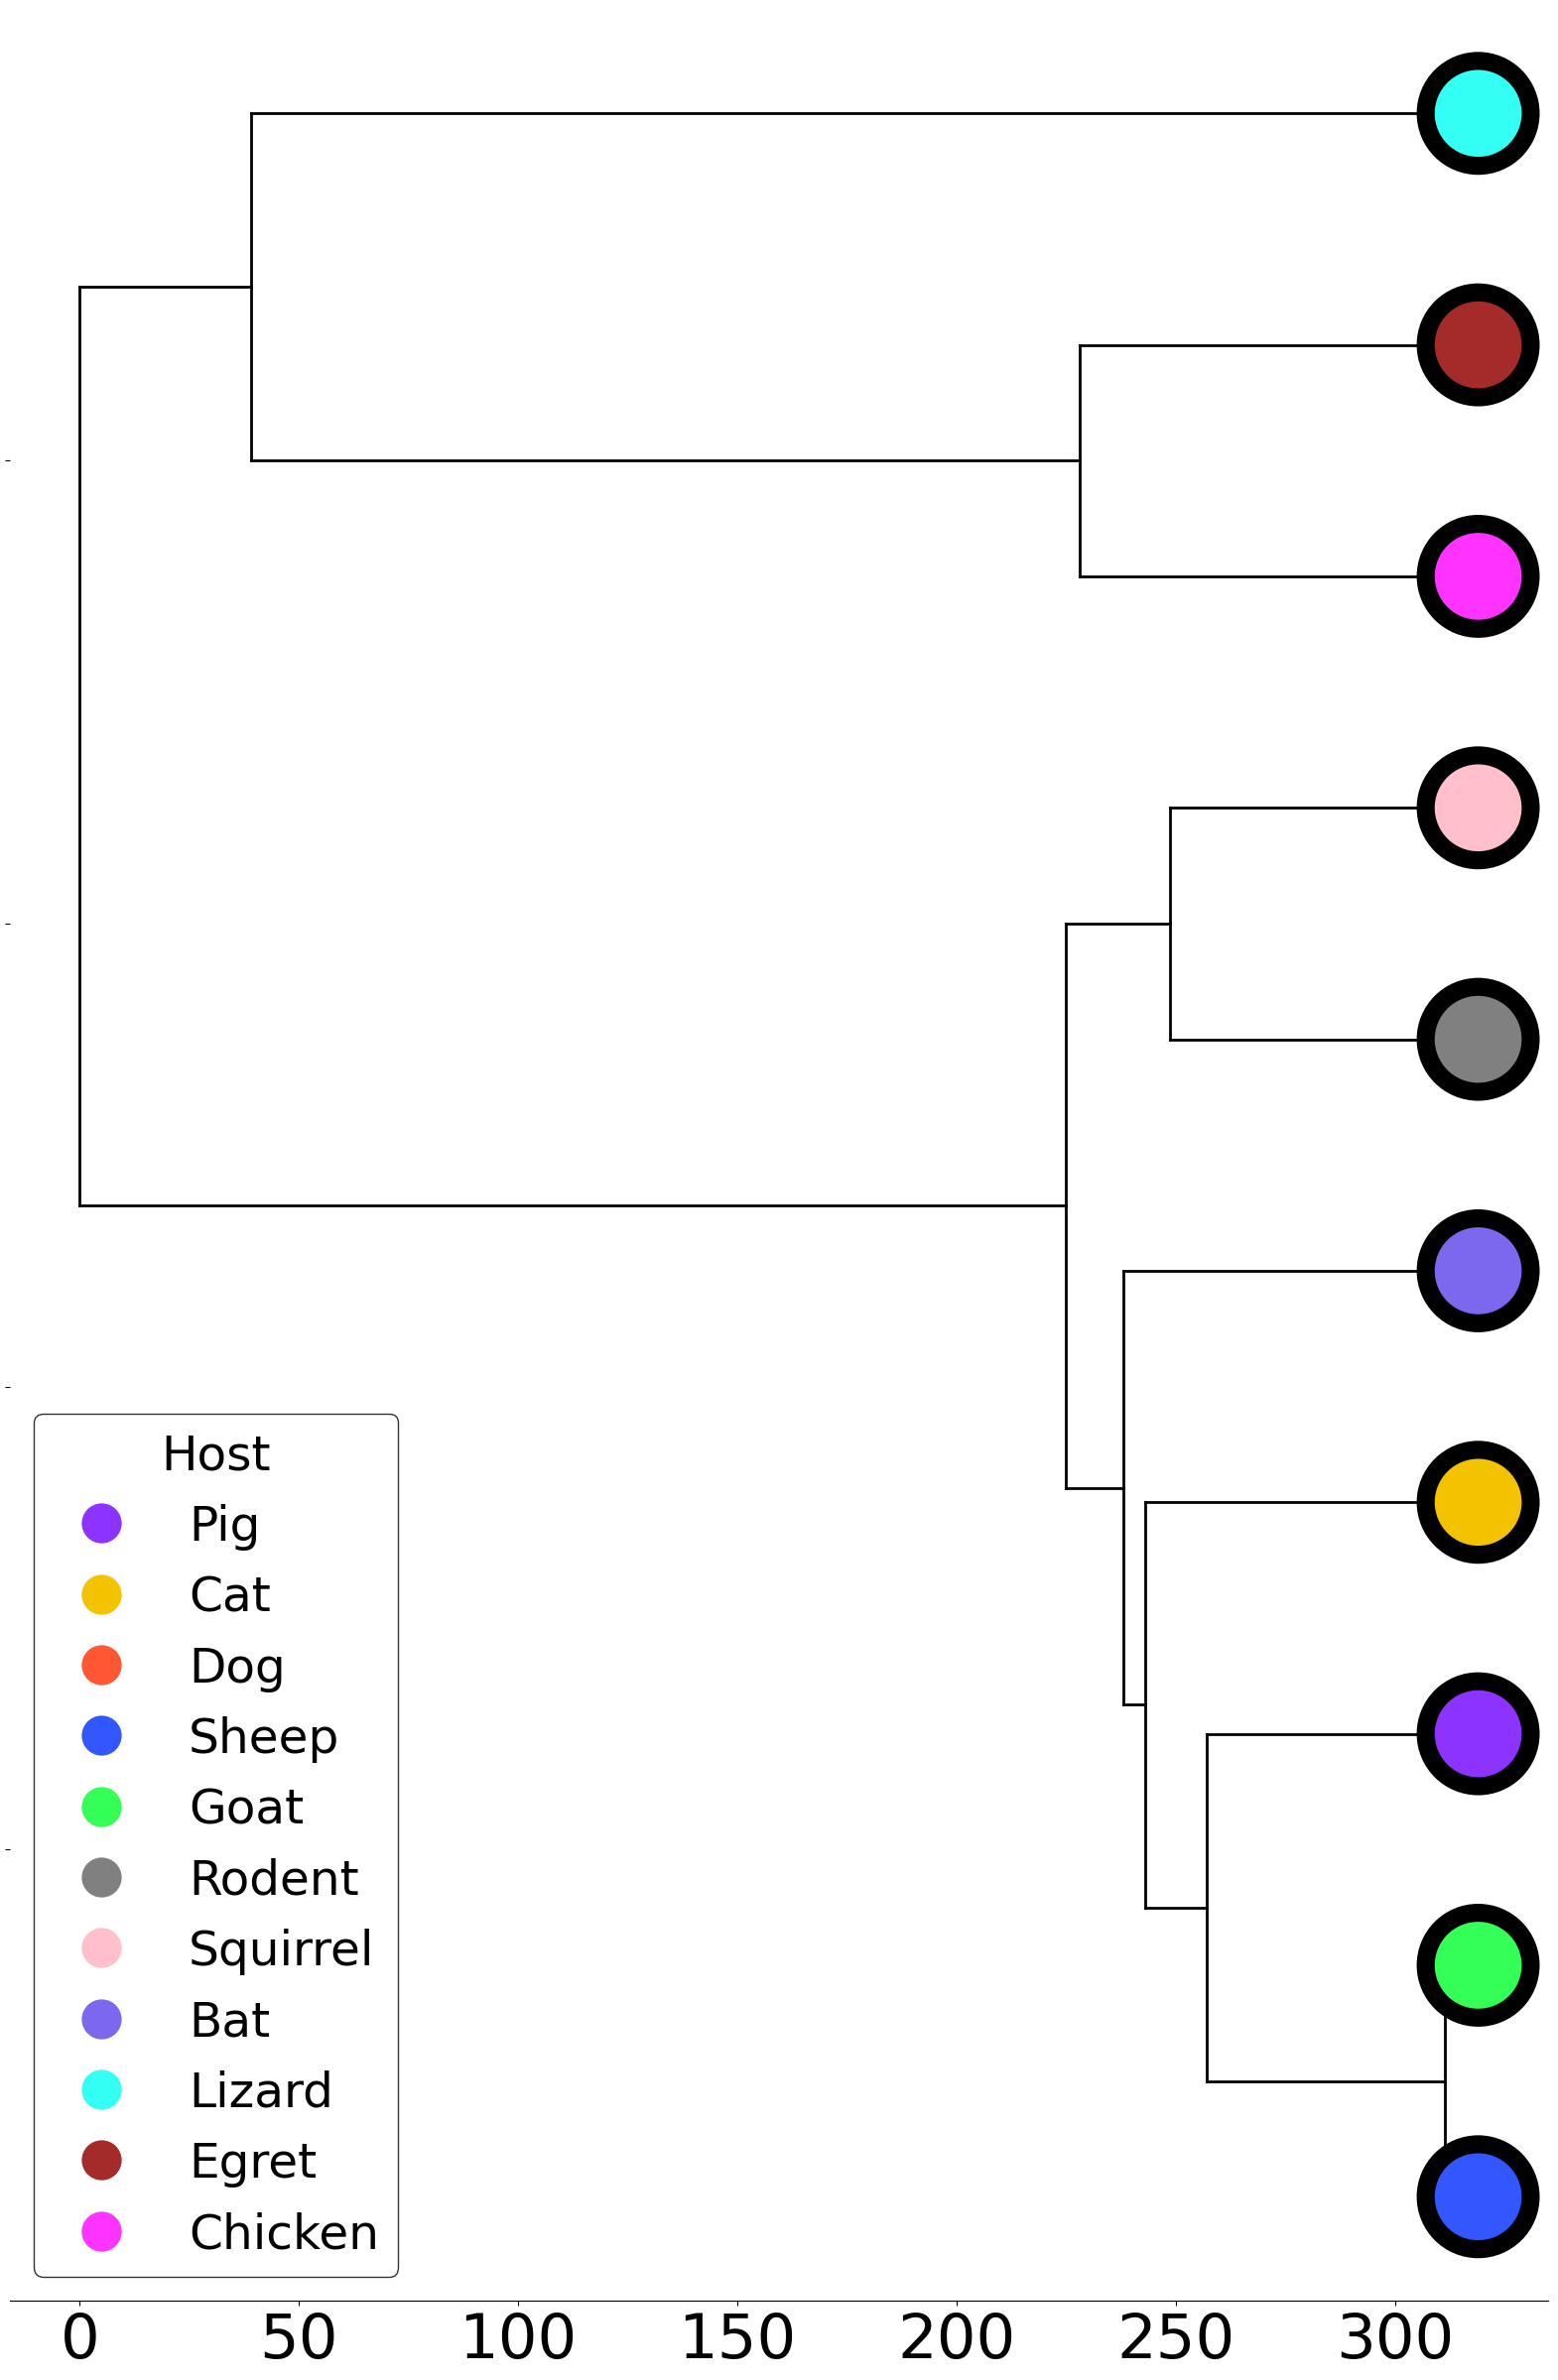

In [3]:
import re
import baltic as bt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl

# 1) Read and clean the Newick string
infile  = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Complete_host.nwk"
outfile = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Complete_host_stripped.nwk"

with open(infile, 'r') as f:
    newick = f.read()
branchWidth=20
# Remove any '123' that immediately precedes a colon (i.e. internal‐node labels)
cleaned = re.sub(r"'[0-9]+'(?=:)", "", newick)

with open(outfile, 'w') as f:
    f.write(cleaned)

# 2) Load the cleaned tree
my_tree = bt.loadNewick(outfile, absoluteTime=False)

# 3) Set up the figure
fig, ax = plt.subplots(figsize=(20, 30), facecolor='w')
my_tree.treeStats()

# 4) Colour dictionary
col_dict = {
    'Pig':     '#8C33FF',
    'Cat':     '#F4C300',
    'Dog':     '#FF5733',
    'Sheep':   '#3357FF',
    'Goat':    '#33FF57',
    'Rodent':  'grey',
    'Squirrel':'#FFC0CB',
    'Bat':     '#7B68EE',
    'Lizard':  '#33FFF5',
    'Egret':   '#A52A2A',
    'Chicken': '#FF33FF'
}

# 5) Plotting helpers
x_attr = lambda k: k.height
s_func = lambda k: 4000 - 20 * k.height / my_tree.treeHeight
c_func = lambda k: col_dict.get(k.name, '#C0C0C0')

# 6) Draw the tree and tips
my_tree.plotTree(ax, x_attr=x_attr)
my_tree.plotPoints(ax,
                   size=s_func,
                   colour=c_func,
                   x_attr=x_attr)

# 7) Aesthetic tweaks
mpl.rcParams['font.family'] = 'sans-serif'
for loc in ['top','right','left']:
    ax.spines[loc].set_visible(False)
ax.set_yticklabels([])
plt.xticks(fontsize=45)

# 8) Legend
legend_elements = [
    Line2D([0],[0], marker='o', color='w', label=host,
           markersize=30, markerfacecolor=color)
    for host, color in col_dict.items()
]
legend = ax.legend(handles=legend_elements,
                   loc='lower left',
                   title="Host",
                   title_fontsize=35,
                   fontsize=35)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')

# 9) Save & show
plt.savefig("/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Complete_sampled_phylo.png", bbox_inches='tight', dpi=300)
plt.show()



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


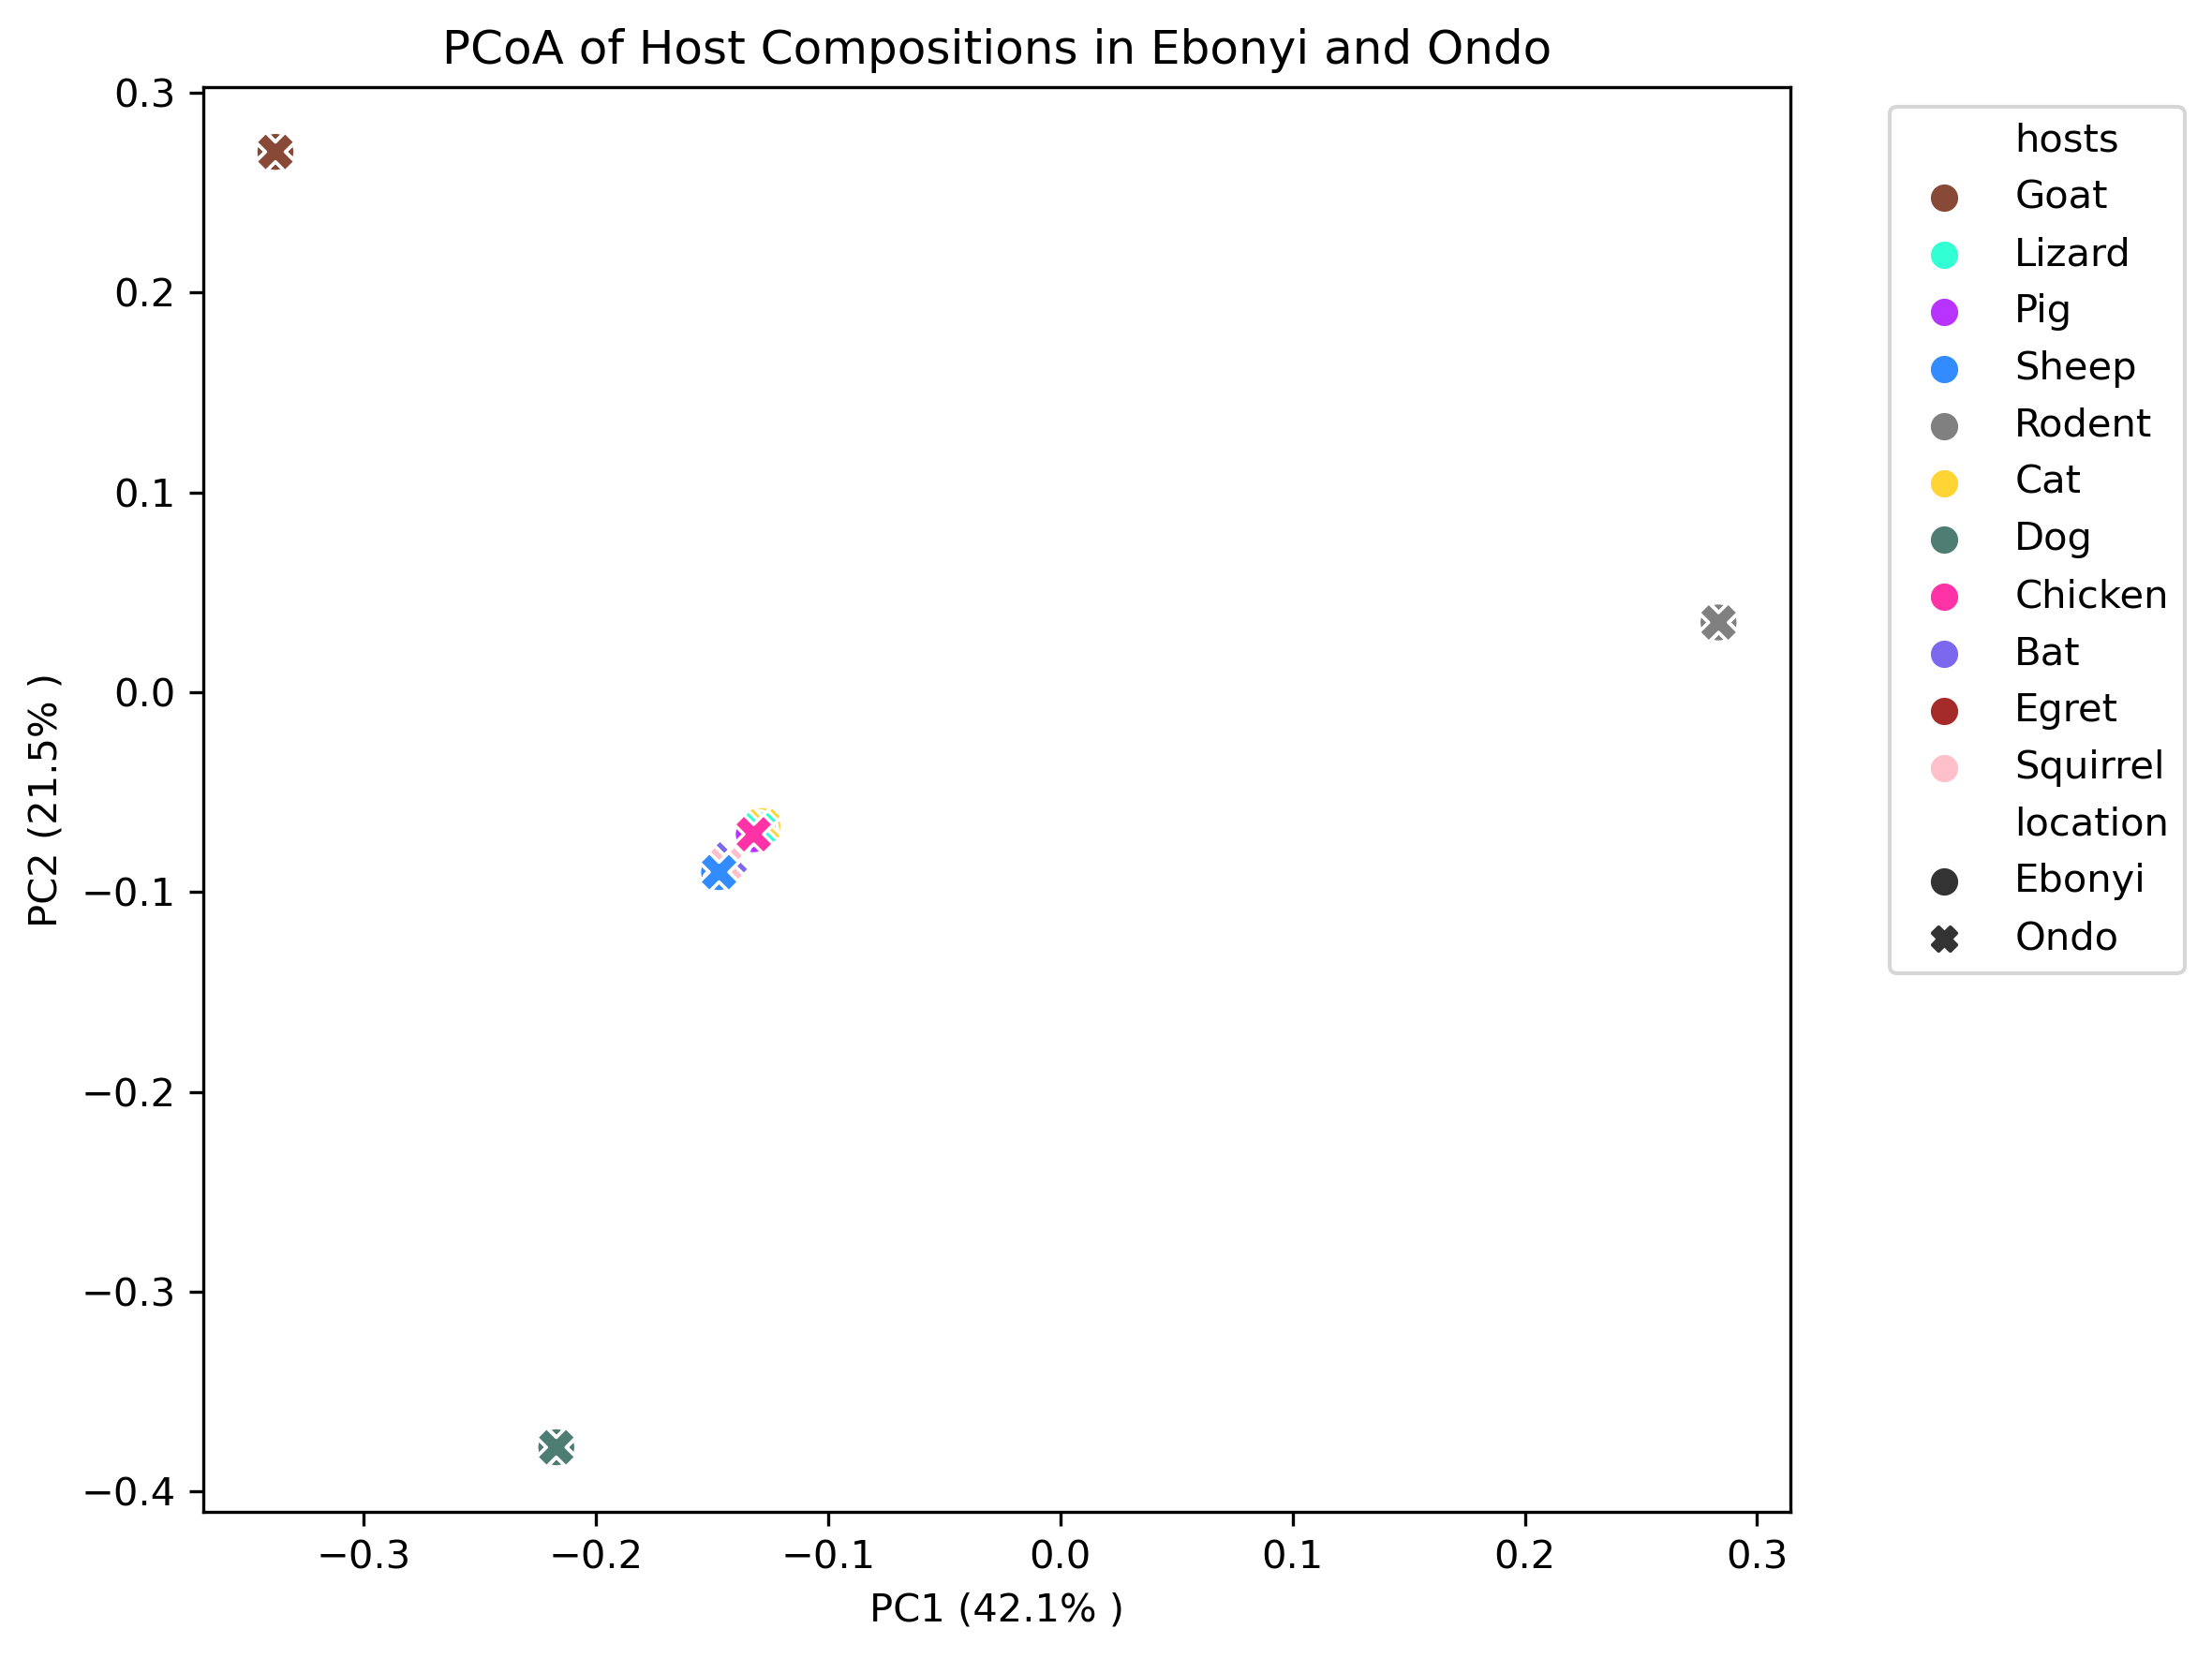

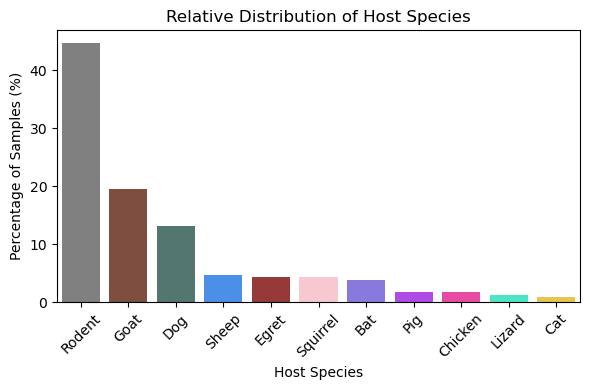

In [84]:
# ------------------------------
#   1. IMPORT PACKAGES
# ------------------------------
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# For computing Jaccard distances
from sklearn.metrics import pairwise_distances

# For PCoA via scikit-bio
!pip install scikit-bio --quiet  # Ensure scikit-bio is installed (comment out if already installed)
from skbio.stats.ordination import pcoa
from skbio import DistanceMatrix


# ------------------------------
#   2. LOAD DATA & BUILD P/A MATRIX
# ------------------------------
# NOTE: Change the file path to match your environment
data = pd.read_csv("/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Senzor_location.csv")

# Create a presence-absence matrix
presence_absence = pd.get_dummies(data, columns=["hosts"], prefix="", prefix_sep="")
presence_absence = presence_absence.groupby("NewIDseqName", as_index=False).max()

# Set the sample names as the index
pa_matrix = presence_absence.set_index("NewIDseqName")

# Convert the DataFrame to a NumPy array
pa_matrix_array = pa_matrix.to_numpy()


# ------------------------------
#   3. CALCULATE JACCARD DISTANCE
# ------------------------------
dist_matrix = pairwise_distances(pa_matrix_array, metric="jaccard")


# ------------------------------
#   4. CONVERT TO SCIKIT-BIO DISTANCEMATRIX
# ------------------------------
sample_ids = pa_matrix.index.tolist()
dm = DistanceMatrix(dist_matrix, ids=sample_ids)


# ------------------------------
#   5. PERFORM PCoA
# ------------------------------
pcoa_results = pcoa(dm)
coordinates = pcoa_results.samples  # Coordinates in PCo space
explained = pcoa_results.proportion_explained  # Fraction of variance explained per axis


# ------------------------------
#   6. MERGE COORDINATES WITH DATA
# ------------------------------
# The columns in 'coordinates' are labeled 'PC1', 'PC2', 'PC3', etc.
coordinates.reset_index(inplace=True)
coordinates.rename(columns={'index': 'NewIDseqName'}, inplace=True)

# Merge PCoA results with original data on 'NewIDseqName'
merged_data = pd.merge(data, coordinates, on='NewIDseqName', how='left')


# ------------------------------
#   7. PLOT THE FIRST TWO PCoA AXES WITH A DEDUPLICATED LEGEND
# ------------------------------
# Define colors for hosts (example)
host_colors = {
    "Chicken": '#FF33A6', "Bat": '#7B68EE', "Dog": '#4D7D73', "Goat": '#884936',
    "Egret": '#A52A2A', "Cat": '#FFD433', "Sheep": '#338CFF', "Rodent": 'grey',
    "Lizard": '#33FFD4', "Squirrel": '#FFC0CB', "Pig": '#B833FF'
}

plt.figure(figsize=(8,6), dpi=300 )

# Fraction of variation explained by PC1 and PC2
pc1_var = explained[0] * 100
pc2_var = explained[1] * 100

# Create scatterplot with both hue and style
ax = sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="hosts", 
    style="location",
    data=merged_data, 
    palette=host_colors,
    s=100
)

plt.title("PCoA of Host Compositions in Ebonyi and Ondo")
plt.xlabel(f"PC1 ({pc1_var:.1f}% )")
plt.ylabel(f"PC2 ({pc2_var:.1f}% )")

# Retrieve current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Remove duplicates while preserving order
unique = []
seen = set()
for handle, label in zip(handles, labels):
    if label not in seen:
        unique.append((handle, label))
        seen.add(label)

# Set the new legend; adjust the bbox as needed
ax.legend(*zip(*unique), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# ------------------------------
#   8. (OPTIONAL) BAR CHART OF SPECIES %
# ------------------------------
# If you want to show a bar chart of the percentage of samples by species:
host_counts = data["hosts"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
sns.barplot(x=host_counts.index, y=host_counts.values, palette=host_colors)
plt.xlabel("Host Species")
plt.ylabel("Percentage of Samples (%)")
plt.title("Relative Distribution of Host Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




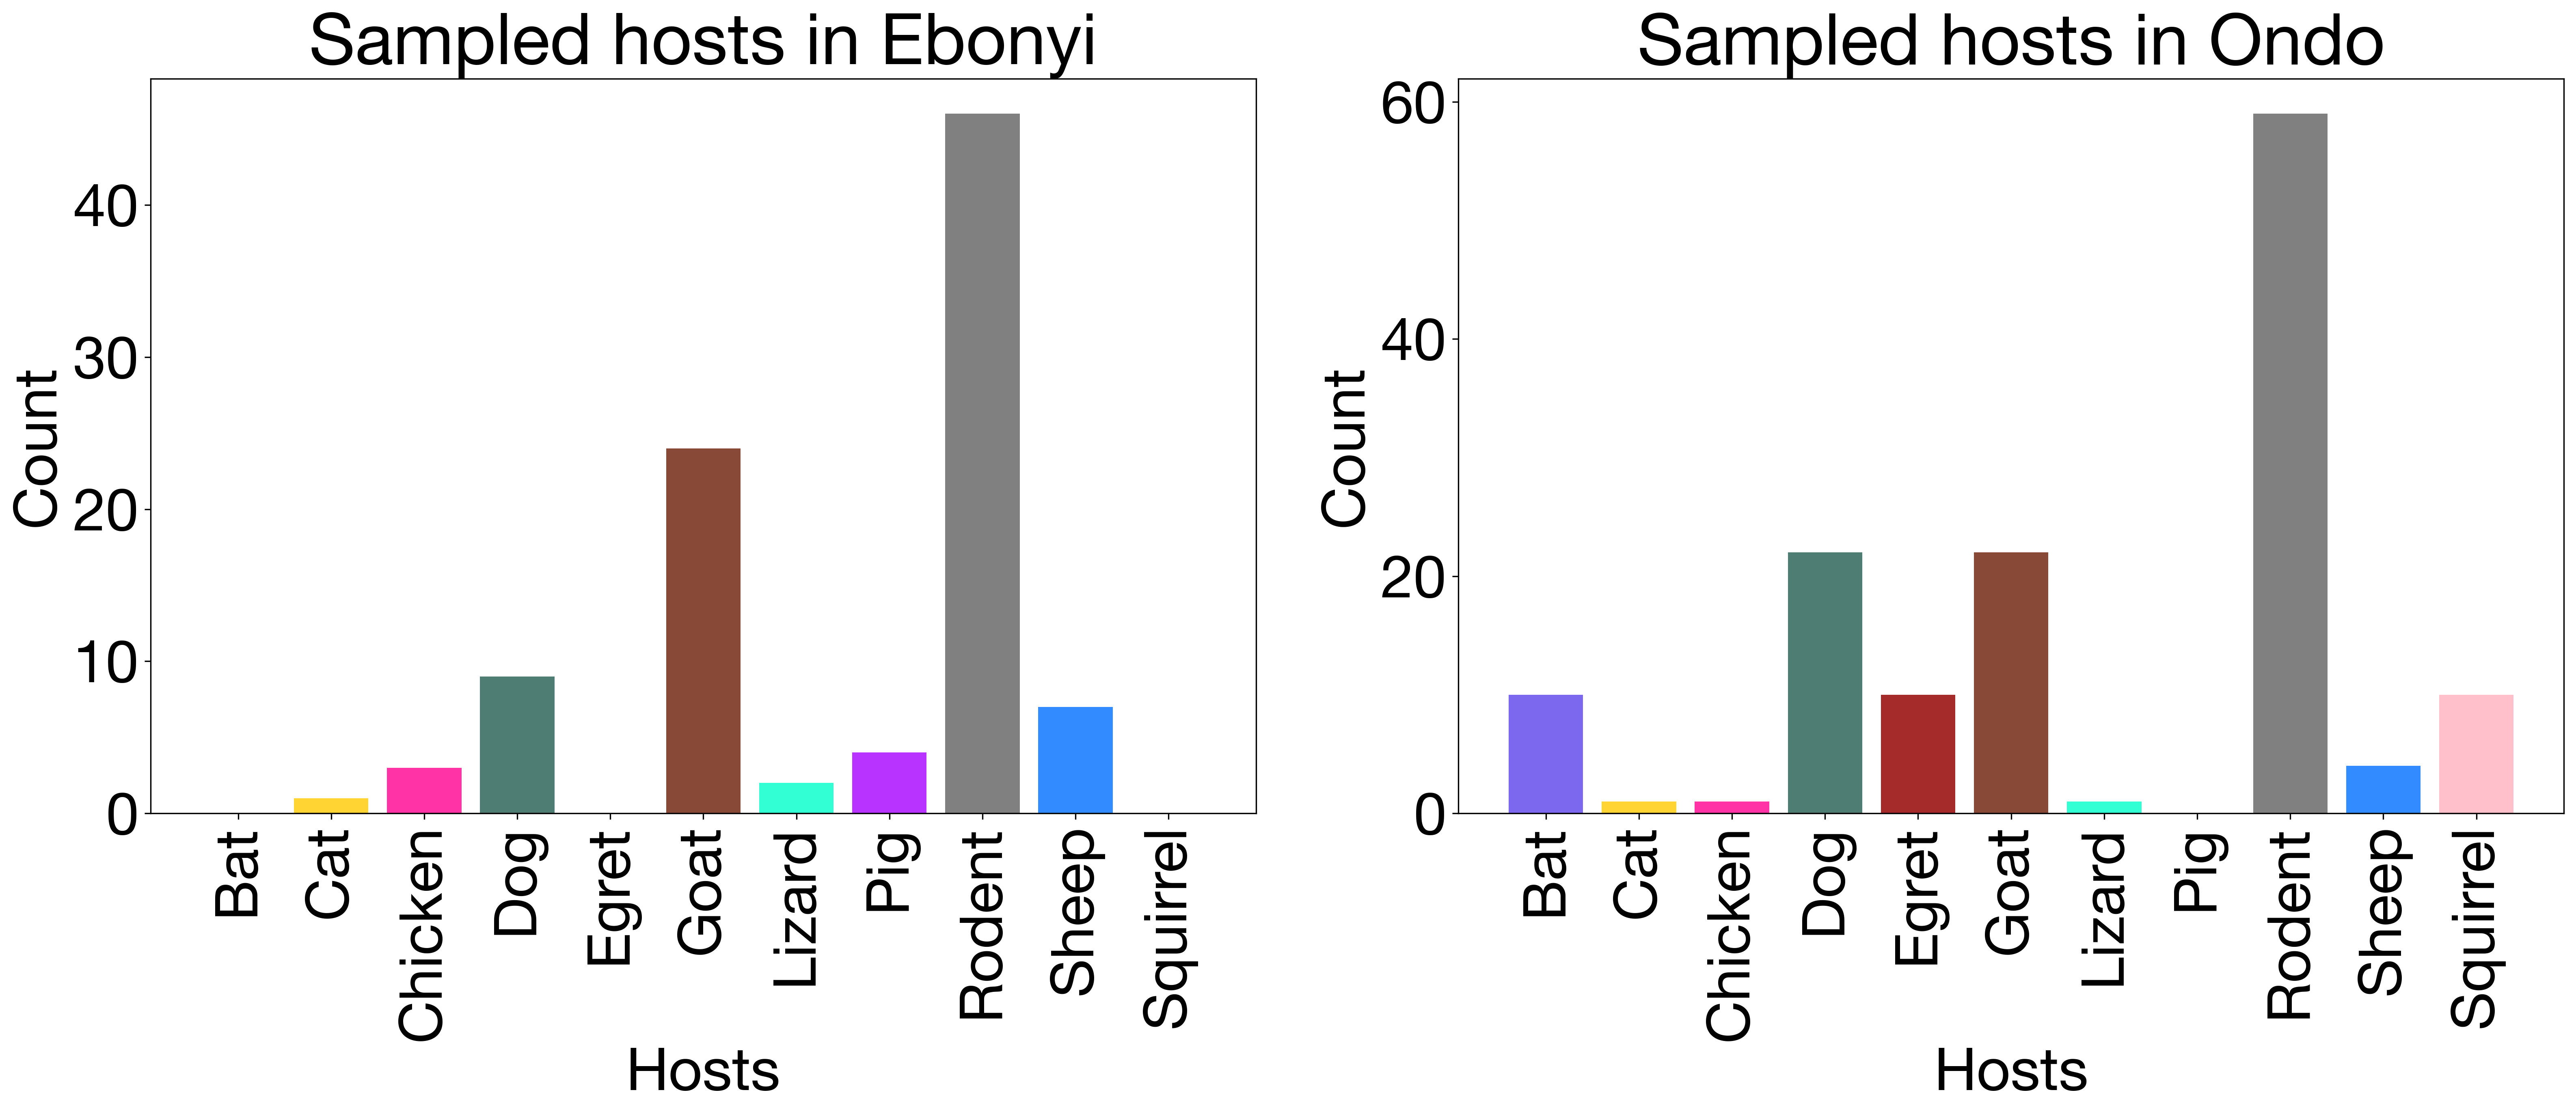

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the data
# ------------------------------
# If a host has no entry for Ebonyi or Ondo, treat it as 0.
data_dict = {
    "hosts":    ["Bat", "Cat", "Chicken", "Dog", "Egret", "Goat", "Lizard", "Pig", "Rodent", "Sheep", "Squirrel"],
    "Ebonyi":   [0,     1,     3,         9,     0,       24,     2,        4,     46,      7,       0],
    "Ondo":     [10,    1,     1,         22,    10,      22,     1,        0,     59,      4,       10]
}

df = pd.DataFrame(data_dict)
df.set_index("hosts", inplace=True)

# ------------------------------
# 2. Define custom colors for each host
# ------------------------------
host_colors = {
    'Chicken': '#FF33A6',
    'Bat': '#7B68EE',
    'Dog': '#4D7D73',
    'Goat': '#884936',
    'Egret': '#A52A2A',
    'Cat': '#FFD433',
    'Sheep': '#338CFF',
    'Rodent': 'grey',
    'Lizard': '#33FFD4',
    'Squirrel': '#FFC0CB',
    'Pig': '#B833FF'
}

# ------------------------------
# 3. Create two histograms side by side
# ------------------------------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10), dpi=300)

# Histogram for Ebonyi
axes[0].bar(
    x=df.index,
    height=df["Ebonyi"],
    color=[host_colors[host] for host in df.index]
)
axes[0].set_title("Sampled hosts in Ebonyi")
axes[0].set_xlabel("Hosts")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=90)

# Histogram for Ondo
axes[1].bar(
    x=df.index,
    height=df["Ondo"],
    color=[host_colors[host] for host in df.index]
)
axes[1].set_title("Sampled hosts in Ondo")
axes[1].set_xlabel("Hosts")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


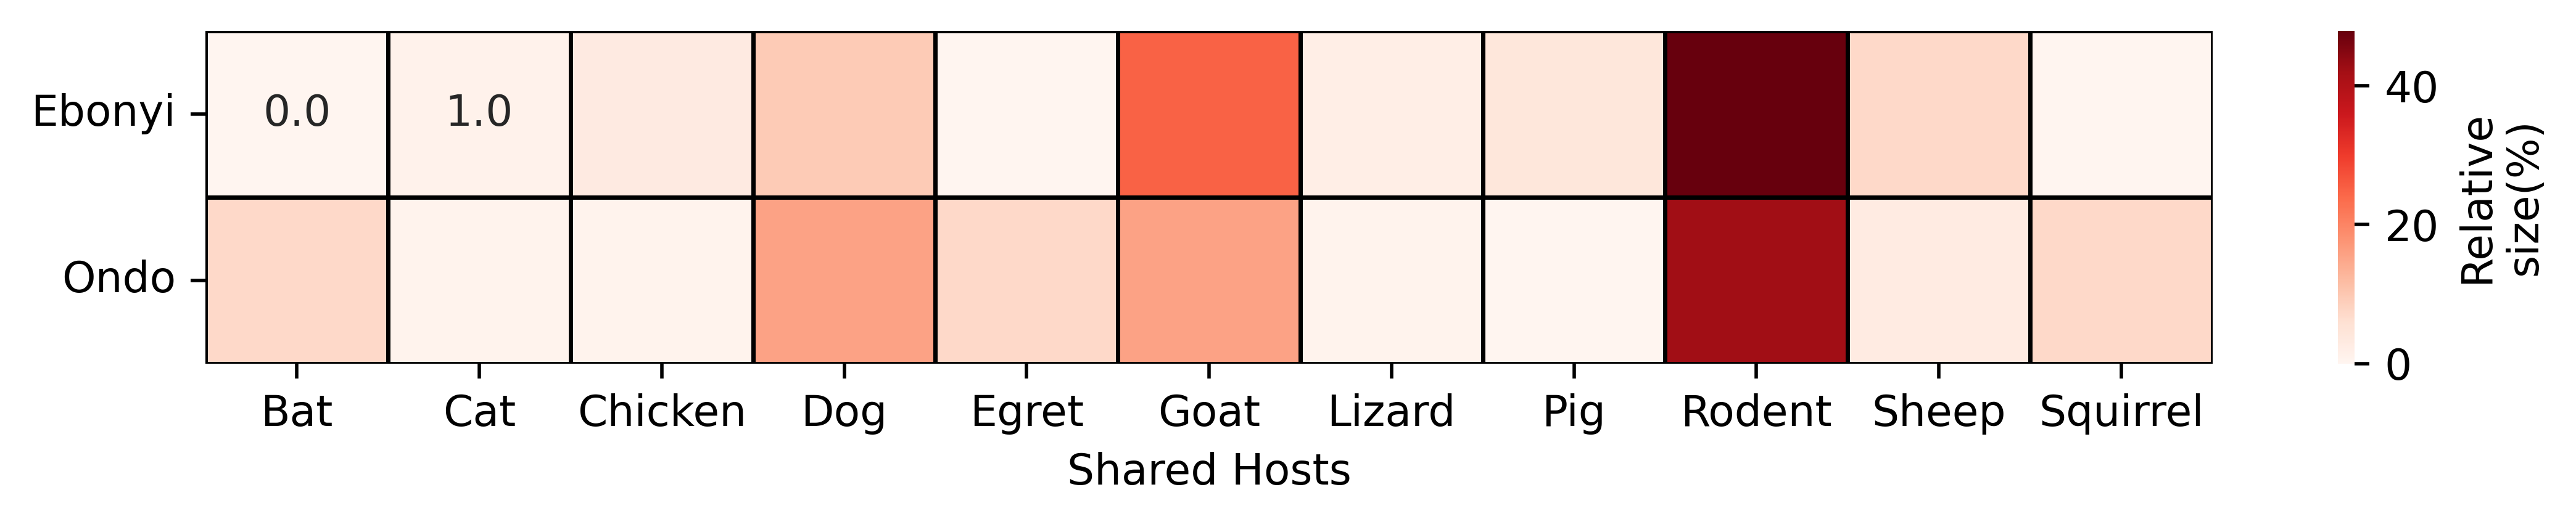

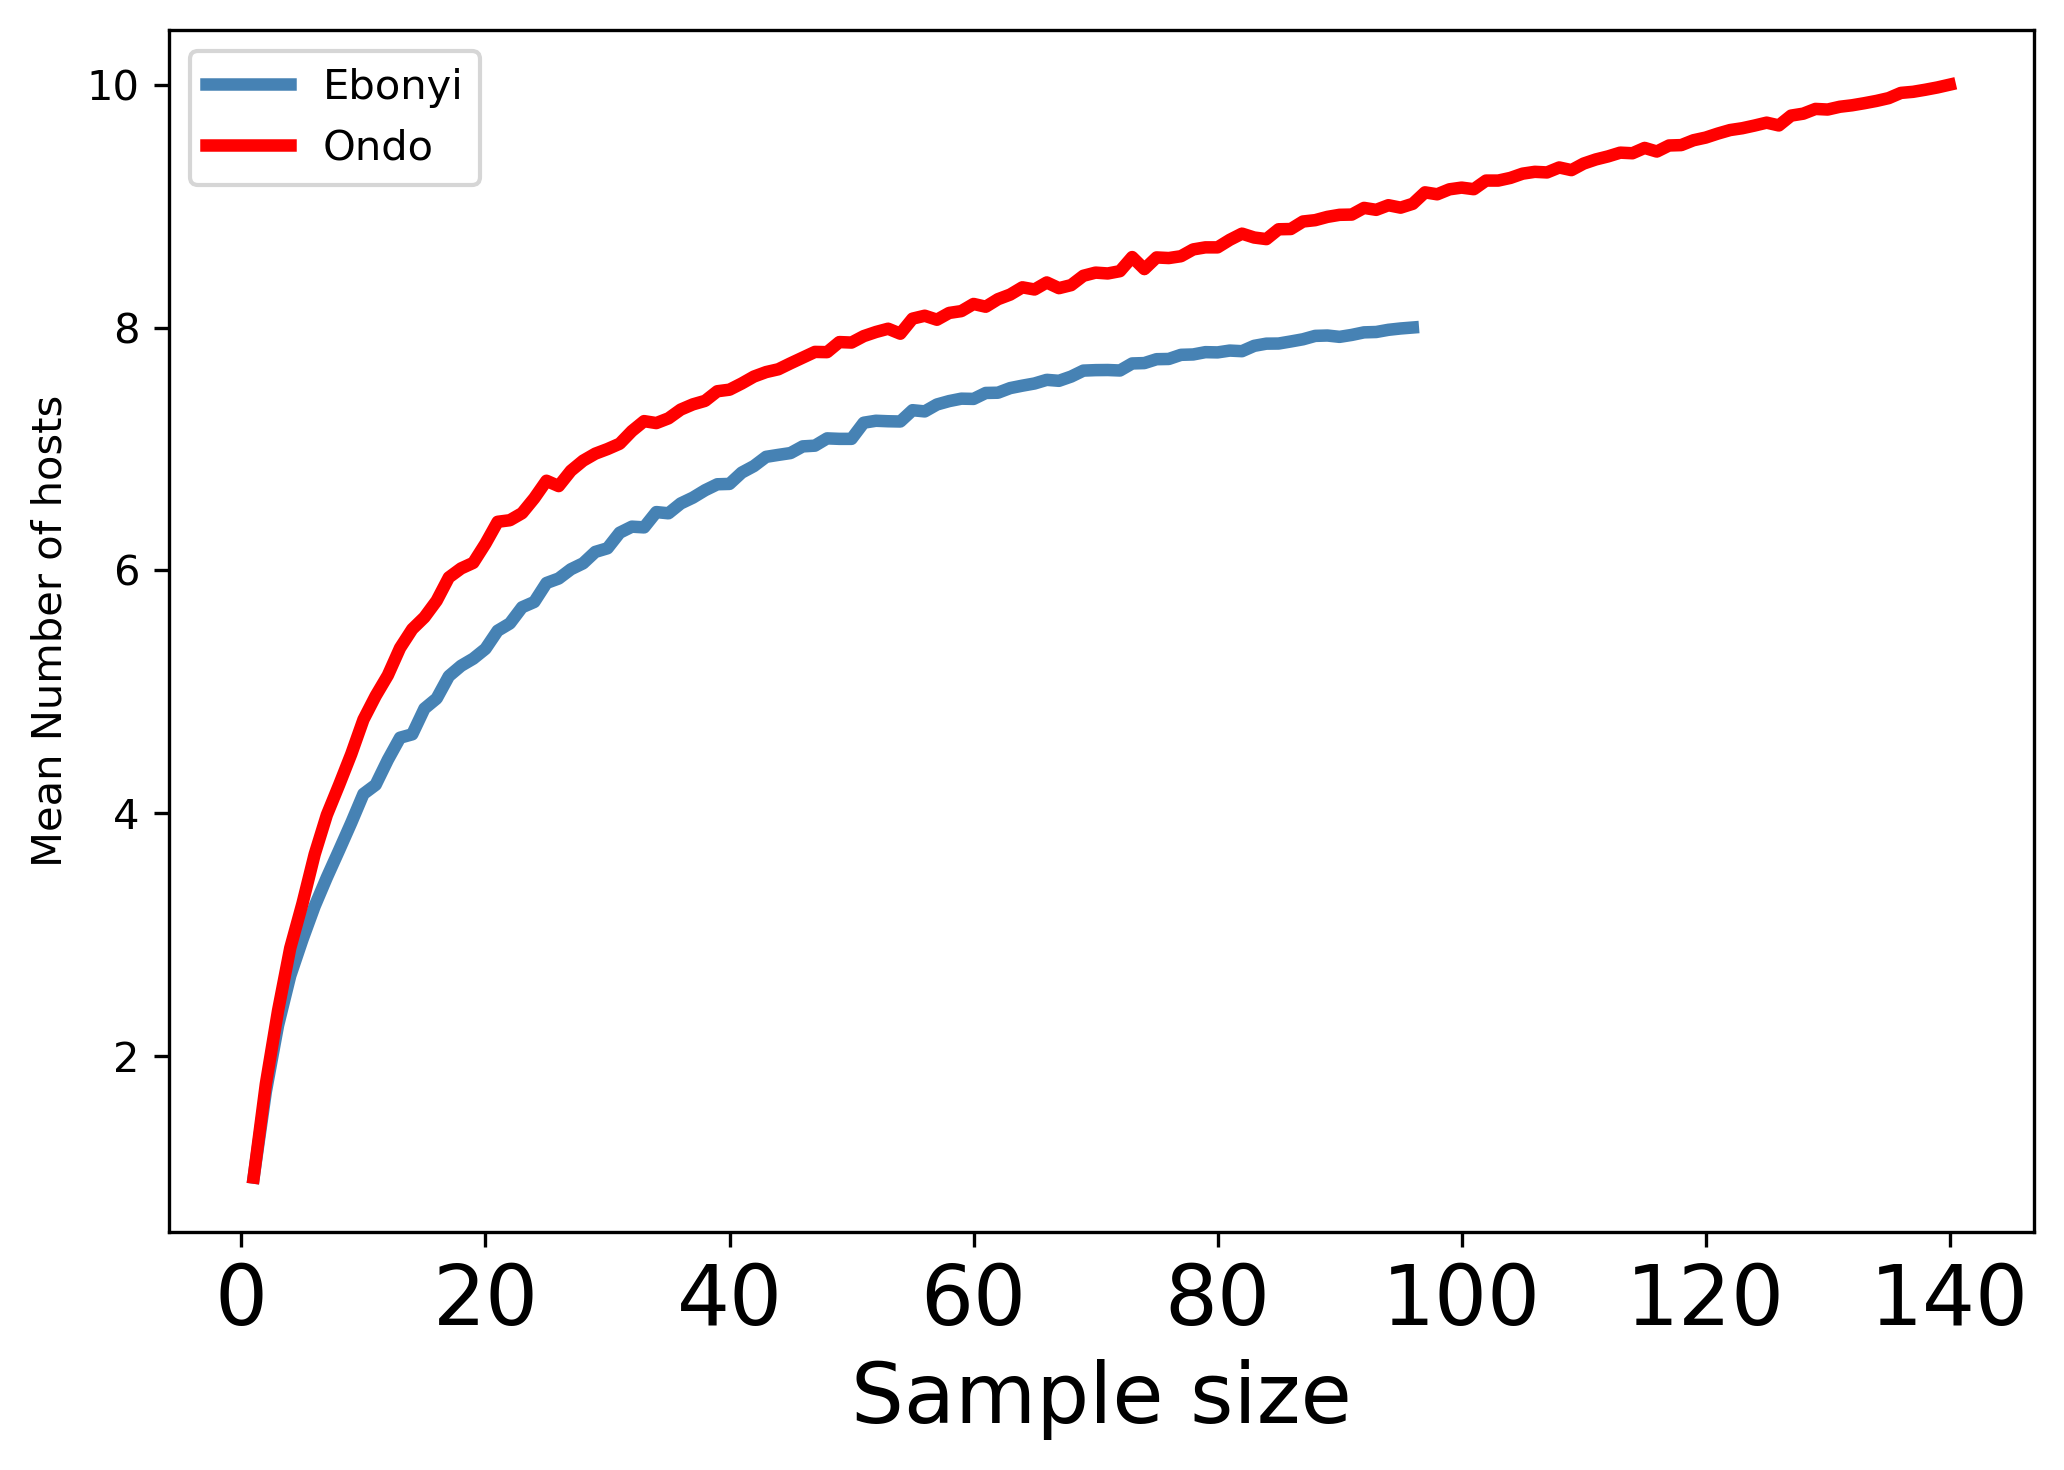

In [216]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define Your Data
# ------------------------------
df = pd.DataFrame({
    "Bat":      [0, 10],
    "Cat":      [1,  1],
    "Chicken":  [3,  1],
    "Dog":      [9,  22],
    "Egret":    [0,  10],
    "Goat":     [24, 22],
    "Lizard":   [2,  1],
    "Pig":      [4,  0],
    "Rodent":   [46, 59],
    "Sheep":    [7,  4],
    "Squirrel": [0, 10]
}, index=["Ebonyi", "Ondo"]).fillna(0)

# (Optional) Set a seed for reproducibility
# random.seed(42)

# ------------------------------
# 2. Rarefaction Function
# ------------------------------
def compute_rarefaction_curve(count_series, n_reps=1000, max_samples=None):
    """
    count_series: pandas Series or dict of host: count
    n_reps: number of replicate draws at each sample size
    max_samples: maximum number of individuals to sample (defaults to total)
    Returns:
       sample_sizes: list of sample sizes from 1..max_samples
       mean_richness: average number of unique hosts for each sample size
    """
    # Create a list of individuals by repeating each host count times
    individuals = []
    for host, c in count_series.items():
        individuals.extend([host] * int(c))
    
    total_individuals = len(individuals)
    if max_samples is None or max_samples > total_individuals:
        max_samples = total_individuals

    sample_sizes = range(1, max_samples + 1)
    mean_richness = []

    # For each sample size, do multiple random draws and measure richness
    for s in sample_sizes:
        replicate_richness = []
        for _ in range(n_reps):
            # Randomly sample s individuals (without replacement)
            subset = random.sample(individuals, s)
            # Count how many unique hosts appear
            replicate_richness.append(len(set(subset)))
        # Average richness across replicates
        mean_richness.append(np.mean(replicate_richness))

    return sample_sizes, mean_richness

# ------------------------------
# 3. Compute Rarefaction for Ebonyi & Ondo
# ------------------------------
ebonyi_counts = df.loc["Ebonyi"]
ondo_counts   = df.loc["Ondo"]

ebonyi_x, ebonyi_y = compute_rarefaction_curve(ebonyi_counts, n_reps=1000)
ondo_x, ondo_y     = compute_rarefaction_curve(ondo_counts, n_reps=1000)

# ------------------------------
# 4. Plot the Rarefaction Curves (Thicker Lines)
# ------------------------------
plt.figure(figsize=(7, 5), dpi=300)

# Increase line thickness with 'linewidth' or 'lw'
plt.plot(ebonyi_x, ebonyi_y, label="Ebonyi", color="Steelblue", linewidth=3)
plt.plot(ondo_x, ondo_y,     label="Ondo",   color="red",       linewidth=3)

plt.xlabel("Sample size", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Mean Number of hosts")
plt.legend()
plt.tight_layout()
plt.show()


In [222]:
import pandas as pd

# 1. Load the two CSV files
metadata_df = pd.read_csv("/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Model_analysis_DNA_RNA_SENZOR.csv")
model_df = pd.read_csv("/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Model_analysis_DNA_RNA_SENZOR_with_sample_type.csv")

# 2. Extract only the columns we need from the metadata
#    (Here, we're assuming you only want "NewIDseqName" and "sample_type".)
metadata_subset = metadata_df[["NewIDseqName", "sample_type"]]

# 3. Rename "NewIDseqName" to "sample" so we can merge on the same column name
metadata_subset.rename(columns={"NewIDseqName": "sample"}, inplace=True)

# 4. Merge model_df with metadata_subset on "sample"
#    Use a left merge to keep all rows from model_df and match sample_type where possible.
merged_df = model_df.merge(metadata_subset, on="sample", how="left")

# 5. Write out the updated DataFrame to a new CSV (optional)
merged_df.to_csv("/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/Model_analysis_DNA_RNA_SENZOR_with_sample_type.csv", index=False)

print("Merged CSV with sample_type added has been saved.")


Merged CSV with sample_type added has been saved.


/var/folders/xt/vz8fznds4hdbfcxyds95mtp00000gp/T/ipykernel_45085/3219012892.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_subset.rename(columns={"contig_name": "contig_name"}, inplace=True)


In [234]:
#!/usr/bin/env python3

import csv
import os
import re
from Bio import SeqIO

# Path to the CSV file (update filename as needed)
CSV_FILE = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Rodents/Coronavirus_contigs.csv"

# Directory containing all sample FASTA files
FASTA_DIR = "/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Rodents/Rodents_senzor_project_16385_contigs"

# Output directory for virus-specific extracted FASTA files
OUTPUT_DIR = "extracted_contigs_by_virus"

# CSV delimiter (set to "\t" for tab-separated or "," for comma-separated)
DELIMITER = ","

def sanitize_filename(name: str) -> str:
    """
    Convert a virus name into a safe filename by replacing spaces with underscores
    and removing non-alphanumeric characters (except underscores and dashes).
    """
    fname = name.replace(" ", "_")
    fname = re.sub(r"[^A-Za-z0-9_\-]+", "", fname)
    return fname

def extract_node_id(contig_name: str) -> str:
    """
    From the CSV contig_name, extract the node id by finding the substring
    that starts with "_NODE_". For example, given:

      SENONOWGOT003_RS_S79_673627_NODE_46693_length_153_cov_37.263158

    it returns:

      NODE_46693_length_153_cov_37.263158
    """
    idx = contig_name.find("_NODE_")
    if idx == -1:
        # If not found, return the original string
        return contig_name
    # Remove the leading underscore so that we get "NODE_..."
    return contig_name[idx+1:]

def main():
    # Create the output directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Dictionary to hold open file handles for each virus (keyed by virus name)
    virus_file_handles = {}

    with open(CSV_FILE, "r", encoding="utf-8") as cf:
        reader = csv.DictReader(cf, delimiter=DELIMITER)
        for row in reader:
            sample = row["sample"]
            csv_contig = row["contig_name"]
            virus_name = row["name"]

            # Extract the node id (e.g. "NODE_46693_length_153_cov_37.263158")
            node_id = extract_node_id(csv_contig)

            # Build the FASTA filename for the sample
            fasta_filename = f"{sample}_contigs_nh.fasta"
            fasta_path = os.path.join(FASTA_DIR, fasta_filename)

            if not os.path.isfile(fasta_path):
                print(f"Warning: FASTA file not found for sample '{sample}': {fasta_path}")
                continue

            # Search for the matching record in the sample FASTA file
            found = False
            for record in SeqIO.parse(fasta_path, "fasta"):
                if record.id == node_id:
                    found = True
                    # Open virus-specific file if not already open
                    if virus_name not in virus_file_handles:
                        out_filename = os.path.join(OUTPUT_DIR, sanitize_filename(virus_name) + ".fasta")
                        virus_file_handles[virus_name] = open(out_filename, "w")

                    out_handle = virus_file_handles[virus_name]
                    # Write a header that includes the sample, node id, and virus name
                    out_header = f">{sample}|{record.id}|{virus_name}\n"
                    out_handle.write(out_header)
                    out_handle.write(str(record.seq) + "\n")
                    break

            if not found:
                print(f"Warning: Contig with node id '{node_id}' not found in {fasta_path}")

    # Close all open virus-specific file handles
    for fh in virus_file_handles.values():
        fh.close()

if __name__ == "__main__":
    main()

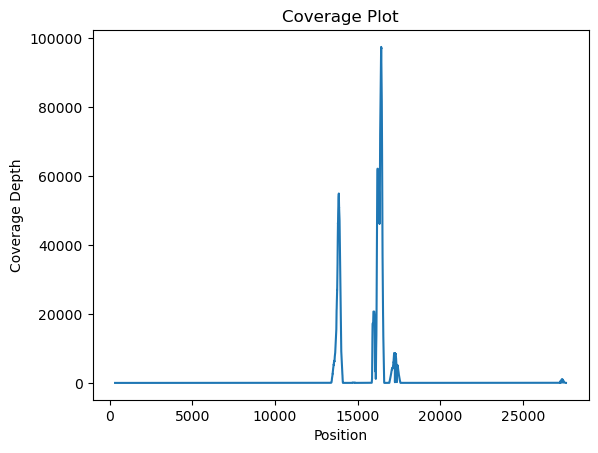

In [236]:
import matplotlib.pyplot as plt

# Read the coverage file
coverage_data = []
with open("/Volumes/aine_store/SENZOR_project/OD_ZAD_AGR007_LUNG_S52/coverage.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        coverage_data.append((int(parts[1]), int(parts[2])))  # position, coverage

positions, coverage = zip(*coverage_data)

# Plot the coverage
plt.plot(positions, coverage)
plt.title("Coverage Plot")
plt.xlabel("Position")
plt.ylabel("Coverage Depth")
plt.show()
